In [ ]:
!pip install transformers[sentencepiece] -q
!pip install sentencepiece -q

# Basic Part

## Get the data

In [ ]:
!pip install datasets -q
!pip install imbalanced-learn -q

In [ ]:
!pip install wordcloud -q

In [ ]:
!pip install tensorflow -q

In [ ]:
!pip install scikit-learn==1.2.2 -q

In [ ]:
import os
import random
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from transformers import pipeline, set_seed

### Get the Financial PhraseBank dataset

In [ ]:
raw_datasets = load_dataset('financial_phrasebank','sentences_allagree', split="train")
raw_datasets

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2264
})

### Look at the data

In [ ]:
raw_datasets[0]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'label': 1}

In [ ]:
raw_datasets.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [ ]:
len(raw_datasets)

2264

In [ ]:
sentences = raw_datasets['sentence']
labels = raw_datasets['label']
len(sentences), len(labels)

(2264, 2264)

### Define performance measures

For this classification task, I will use two metrics: accuracy and log loss during the model training, and I will use precision, recall, F1 score, and confusion matrix to evaluate the model.

### Split the raw datasets to create a train, validation, and test set

In [ ]:
train_test_split = raw_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']
validation_test_split = test_dataset.train_test_split(test_size=0.5)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']
print("Train Dataset:", train_dataset)
print("Validation Dataset:", validation_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: Dataset({
    features: ['sentence', 'label'],
    num_rows: 1811
})
Validation Dataset: Dataset({
    features: ['sentence', 'label'],
    num_rows: 226
})
Test Dataset: Dataset({
    features: ['sentence', 'label'],
    num_rows: 227
})


## Exploratory Data Analysis

### Basic statistics

Mistake: I should focus on the train data for analysis to prevent cheating.

In [ ]:
# print("Number of examples in training set:", len(train_dataset))
# print("Number of examples in validation set:", len(validation_dataset))
# print("Number of examples in test set:", len(test_dataset))

# # Class distribution
# from collections import Counter

# train_labels = [example['label'] for example in train_dataset]
# validation_labels = [example['label'] for example in validation_dataset]
# test_labels = [example['label'] for example in test_dataset]

# print("Training set class distribution:", Counter(train_labels))
# print("Validation set class distribution:", Counter(validation_labels))
# print("Test set class distribution:", Counter(test_labels))

### Calculating the number of sentences in each sub-dataset

In [ ]:
# 'label' is encoded as 0 for negative, 1 for neutral, 2 for positive

# Segregate sentences based on labels
negative_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 0]
neutral_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 1]
positive_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 2]

print("Number of sentences in training set:", len(train_dataset))
print("Number of sentences in negative set:", len(negative_sentences))
print("Number of sentences in neutral set:", len(neutral_sentences))
print("Number of sentences in positive set:", len(positive_sentences))

# Class distribution
train_labels = [example['label'] for example in train_dataset]
print("Training set class distribution:", Counter(train_labels))

Number of sentences in training set: 1811
Number of sentences in negative set: 245
Number of sentences in neutral set: 1114
Number of sentences in positive set: 452
Training set class distribution: Counter({1: 1114, 2: 452, 0: 245})


### Text length analysis

Mistake: I should focus on the train data for analysis to prevent cheating.

In [ ]:
# # Calculate sentence lengths
# train_lengths = [len(s.split()) for s in train_dataset['sentence']]
# validation_lengths = [len(s.split()) for s in validation_dataset['sentence']]
# test_lengths = [len(s.split()) for s in test_dataset['sentence']]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.hist(train_lengths, bins=30, alpha=0.5, label='Train')
# plt.hist(validation_lengths, bins=30, alpha=0.5, label='Validation')
# plt.hist(test_lengths, bins=30, alpha=0.5, label='Test')
# plt.title('Distribution of Sentence Lengths')
# plt.xlabel('Length')
# plt.ylabel('Number of Sentences')
# plt.legend()
# plt.show()

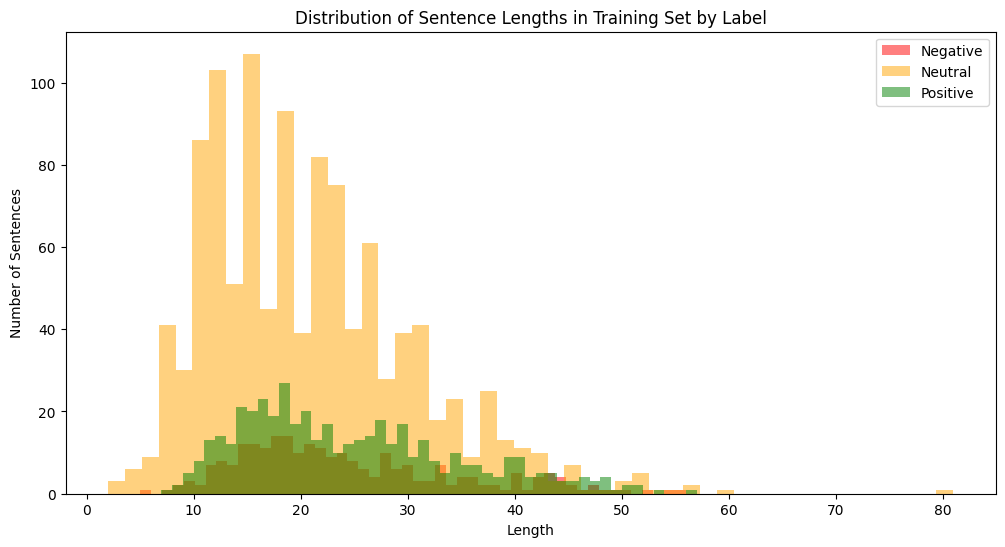

In [ ]:
# Segregate sentences based on labels
negative_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 0]
neutral_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 1]
positive_sentences = [sentence for sentence, label in zip(train_dataset['sentence'], train_dataset['label']) if label == 2]

# Calculate sentence lengths for each category
negative_lengths = [len(sentence.split()) for sentence in negative_sentences]
neutral_lengths = [len(sentence.split()) for sentence in neutral_sentences]
positive_lengths = [len(sentence.split()) for sentence in positive_sentences]

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(negative_lengths, bins=50, alpha=0.5, label='Negative', color='red')
plt.hist(neutral_lengths, bins=50, alpha=0.5, label='Neutral', color='orange')
plt.hist(positive_lengths, bins=50, alpha=0.5, label='Positive', color='green')
plt.title('Distribution of Sentence Lengths in Training Set by Label')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

In [ ]:
max_negative_lengths = max(negative_lengths)
max_neutral_lengths = max(neutral_lengths)
max_positive_lengths = max(positive_lengths)

print("Maximum length in negative set:", max_negative_lengths)
print("Maximum length in neutral set:", max_neutral_lengths)
print("Maximum length in positive set:", max_positive_lengths)

Maximum length in negative set: 56
Maximum length in neutral set: 81
Maximum length in positive set: 57


### Word Frequency Analysis

Improvement: Remove some common unhelpful words for sentiment analysis and do word frequency analysis specifically for the negative, neutral, and positive set.

In [ ]:
# from collections import Counter
# import itertools

# # Get most common words
# train_words = list(itertools.chain(*[s.split() for s in train_dataset['sentence']]))
# common_words = Counter(train_words).most_common(20)

# print("Most common words in the training set:", common_words)

In [ ]:
# Add more words to the stopwords set
additional_stopwords = {'.', ',', '(', ')', '%', "'s", 'will', 'now', 'said', 'say', 'says', 'just', 'also'}
STOPWORDS.update(additional_stopwords)

# Function to get word frequencies while excluding stopwords
def get_word_frequencies(sentences):
    words = []
    for sentence in sentences:
        words.extend(word for word in sentence.lower().split() if word not in STOPWORDS)
    return Counter(words)

# Get word frequencies for each sentiment
negative_word_freq = get_word_frequencies(negative_sentences)
neutral_word_freq = get_word_frequencies(neutral_sentences)
positive_word_freq = get_word_frequencies(positive_sentences)

# Print the 10 most common words for each sentiment
print("Common words in negative sentences:", negative_word_freq.most_common(10))
print("Common words in neutral sentences:", neutral_word_freq.most_common(10))
print("Common words in positive sentences:", positive_word_freq.most_common(10))

Common words in negative sentences: [('eur', 205), ('mn', 152), ('profit', 102), ('net', 69), ('sales', 57), ('operating', 56), ('quarter', 54), ('period', 51), ('million', 49), ('mln', 49)]
Common words in neutral sentences: [('company', 176), ('eur', 103), ('finland', 89), ('shares', 85), ('group', 75), (':', 74), ('business', 71), ('million', 68), ('services', 63), ('share', 55)]
Common words in positive sentences: [('eur', 293), ('mn', 177), ('profit', 130), ('net', 124), ('sales', 100), ('period', 96), ('million', 92), ('finnish', 80), ('mln', 79), ('operating', 77)]


### Word Clouds

Improvement: Remove some common unhelpful words for sentiment analysis and make word clouds specifically for the negative, neutral, and positive set.

In [ ]:
# from wordcloud import WordCloud

# # Example: Word cloud for a specific class
# example_label = train_dataset.features['label'].names[0]
# example_sentences = [s for s, l in zip(train_dataset['sentence'], train_labels) if l == example_label]
# wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(" ".join(example_sentences))

# # Plot
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
# plt.show()

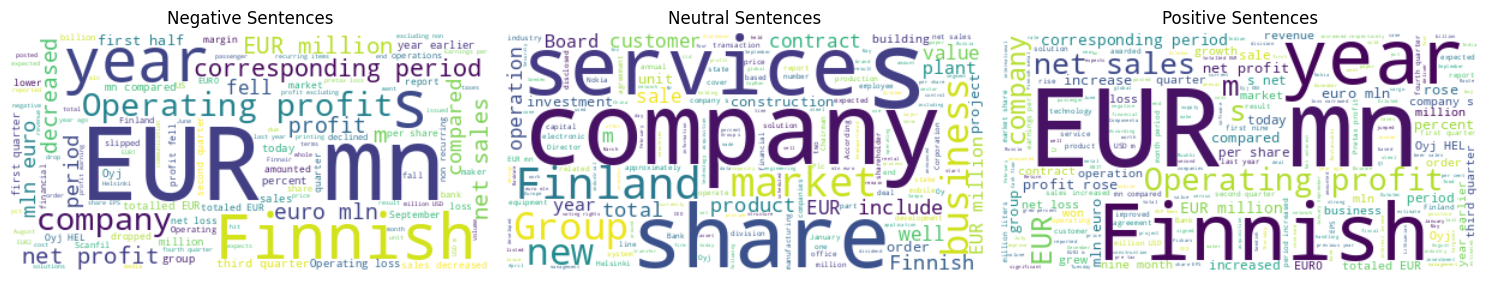

In [ ]:
# Word Cloud for Negative Sentences
negative_text = " ".join(negative_sentences)
wordcloud_negative = WordCloud(stopwords=STOPWORDS, background_color="white").generate(negative_text)

# Word Cloud for Neutral Sentences
neutral_text = " ".join(neutral_sentences)
wordcloud_neutral = WordCloud(stopwords=STOPWORDS, background_color="white").generate(neutral_text)

# Word Cloud for Positive Sentences
positive_text = " ".join(positive_sentences)
wordcloud_positive = WordCloud(stopwords=STOPWORDS, background_color="white").generate(positive_text)

# Plotting the word clouds
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentences')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Sentences')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentences')
plt.axis("off")

plt.tight_layout()
plt.show()

## Prepare the data

Here I chose "distilbert-base-uncased" as the pre-trained model. I collected its tokenizer to tokenize the sentences in the dataset.

### Tokenization

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenized_X_train = tokenizer(train_dataset['sentence'], padding=True, return_tensors="np")
tokenized_X_validation = tokenizer(validation_dataset['sentence'], padding=True, return_tensors="np")
tokenized_X_test = tokenizer(test_dataset['sentence'], padding=True, return_tensors="np")

# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_X_train = dict(tokenized_X_train)
tokenized_X_validation = dict(tokenized_X_validation)
tokenized_X_test = dict(tokenized_X_test)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
y_train = np.array(train_dataset['label'])
y_validation = np.array(validation_dataset['label'])
y_test = np.array(test_dataset['label'])

## Train a Model

### Select a Model

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Setting a model's parameters and optimizer

In [ ]:
batch_size = 8
num_epochs = 3

num_train_steps = len(train_dataset['label']) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

### Function for plotting training result including accuracy and loss

In [ ]:
def plot_training_result(history, model_name):
    fig, axs = plt.subplots( 1, 2, figsize=(12, 5) )

    # Determine the name of the key that indexes into the accuracy metric
    acc_string = 'accuracy'

    # Plot loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model_name + " " + 'model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    # Plot accuracy
    axs[1].plot(history.history[ acc_string ])
    axs[1].plot(history.history['val_' + acc_string ])
    axs[1].set_title(model_name + " " +'model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    return fig, axs

### Function for training a model

In [ ]:
def train_model(model_name, model, optimizer, train_data, validation_data, num_batch, num_epochs):

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
    )

    history = model.fit(
        x=train_data[0],
        y=train_data[1],
        validation_data=(validation_data[0], validation_data[1]),
        batch_size=num_batch,
        callbacks=[early_stopping],
        epochs=num_epochs,
        verbose=0
    )

    plot_training_result(history,  model_name)

    train_score = model.evaluate(train_data[0], train_data[1], verbose=0)
    val_score = model.evaluate(validation_data[0], validation_data[1], verbose=0)
    score = {'train_loss': train_score[0], 'train_accuracy': train_score[1],
             'val_loss': val_score[0], 'val_accuracy': val_score[1]}

    return model, score

### Function for evaluating a model

In [ ]:
def evaluate_model(model, X, y_true, score):
    try:
        y_logits = model.predict(X.batch(1), verbose=0)
    except:
        y_logits = model.predict(X, verbose=0)

    try:
        y_logits = y_logits.logits
    except:
        pass

    test_score = model.evaluate(X, y_true, verbose=0)
    score.update({'test_loss': test_score[0], 'test_accuracy': test_score[1]})


    # Predict the probabilities and labels
    predicted_labels = np.argmax(y_logits, axis=1)
    true_labels = y_true

    classification_summary = classification_report(true_labels, predicted_labels, digits=3, zero_division=0)
    print(classification_summary)

    label_class = ['negative','neutral','positive']
    confused_mat = confusion_matrix(true_labels, predicted_labels)
    sns.set()
    plt.figure(figsize=(10,7))
    sns.heatmap(confused_mat, annot=True, fmt=".2f", xticklabels=label_class, yticklabels=label_class)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return score

This code block is for loading and saving models, but now we don't need it.

In [ ]:
# folder_name = './Model'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)

# from google.colab import drive
# drive.mount('/content/drive')
# # model.save_weights('/content/drive/My Drive/Model/' + file_name)

# model_folder_path = '/content/drive/My Drive/Model'
# if not os.path.exists(model_folder_path):
#     os.makedirs(model_folder_path)

# def model_path(model_name, fine_method, sub_dataset, train_size, dataset_type):
#     sep = '_'
#     file_name = sep.join([model_name.replace('/', '_'), fine_method, sub_dataset, str(train_size), dataset_type])
#     return file_name

# def save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type):
#     file_name = model_path(model_name, fine_method, sub_dataset, train_size, dataset_type)
#     model.save_weights('/content/drive/My Drive/Model/' + file_name)

# def load_model(model_name, fine_method, sub_dataset, train_size, dataset_type):
#     if model_name == 'custom_model':
#         model = custom_model()
#     else:
#         model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
#     file_name = model_path(model_name, fine_method, sub_dataset, train_size, dataset_type)
#     model.load_weights('/content/drive/My Drive/Model/' + file_name)
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-5)
#     model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#     return model

### Function for recording a model summary

In [ ]:
def record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score):
    """
    Record a result in a table for convenient comparison.
    """
    row = pd.DataFrame({'Model':model_name, 'Fine Method': fine_method,
                        'Sub-Dataset': sub_dataset, 'Train Size': train_size, 'Dataset Type': dataset_type,
                        'train loss': score['train_loss'], 'train acc': score['train_accuracy'],
                        'val loss': score['val_loss'], 'val acc': score['val_accuracy'],
                        'test loss': score['test_loss'], 'test acc': score['test_accuracy']}, index = [0])
    summary_table = pd.concat([summary_table, row], ignore_index = True)
    return summary_table

### Summary table for storing different models' details

In [ ]:
summary_table = pd.DataFrame(columns = ['Model', 'Fine Method', 'Sub-Dataset', 'Train Size', 'Dataset Type',
                                        'train loss', 'train acc', 'val loss', 'val acc', 'test loss', 'test acc'])

### Fine-tune only the Classifier head

#### Training the model

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


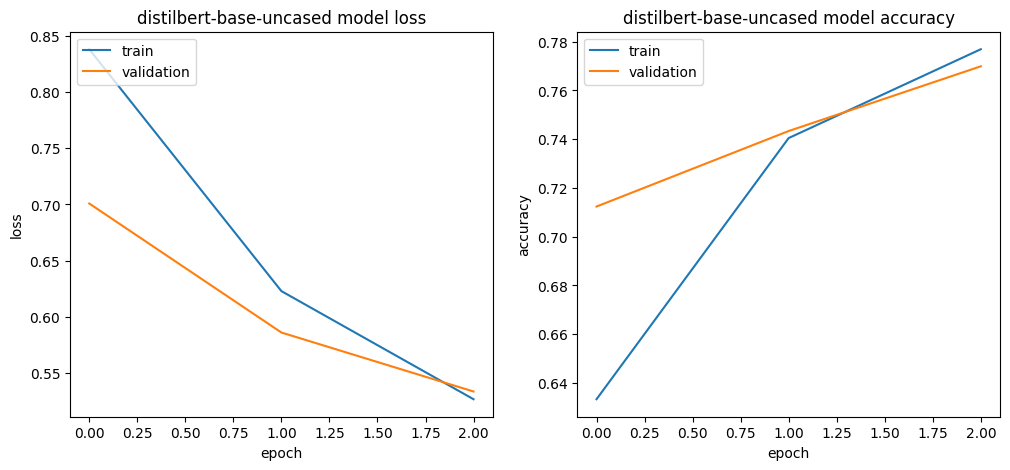

In [ ]:
model_name = "distilbert-base-uncased"
model.layers[0].trainable = False
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()
model, score = train_model(model_name, model, opt, (tokenized_X_train, y_train), (tokenized_X_validation, y_validation), batch_size, num_epochs)

Just directly use model.evalute() instead of the "evaluate" package, so we don't need to install a extra package.

In [ ]:
# validation_preds = model.predict(tf_validation_dataset)["logits"]
# test_preds = model.predict(tf_test_dataset)["logits"]

In [ ]:
# import numpy as np

# class_validation_preds = np.argmax(validation_preds, axis=1)
# print(validation_preds.shape, class_validation_preds.shape)
# class_test_preds = np.argmax(test_preds, axis=1)
# print(test_preds.shape, class_test_preds.shape)

In [ ]:
# !pip install evaluate -q

In [ ]:
# import evaluate

# metric = evaluate.load('accuracy', 'loss')
# print("Validation Accuracy: ", metric.compute(predictions=class_validation_preds, references=validation_dataset["label"]).get('accuracy'))
# metric = evaluate.load('losses')
# print("Validation Accuracy: ", metric.compute(predictions=class_validation_preds, references=validation_dataset["label"]).get('loss'))
# print("Test Accuracy: ", metric.compute(predictions=class_test_preds, references=test_dataset["label"]).get('accuracy'))

#### Evaluating the model

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        31
           1      0.865     0.978     0.918       138
           2      0.592     0.724     0.651        58

    accuracy                          0.780       227
   macro avg      0.486     0.567     0.523       227
weighted avg      0.677     0.780     0.725       227



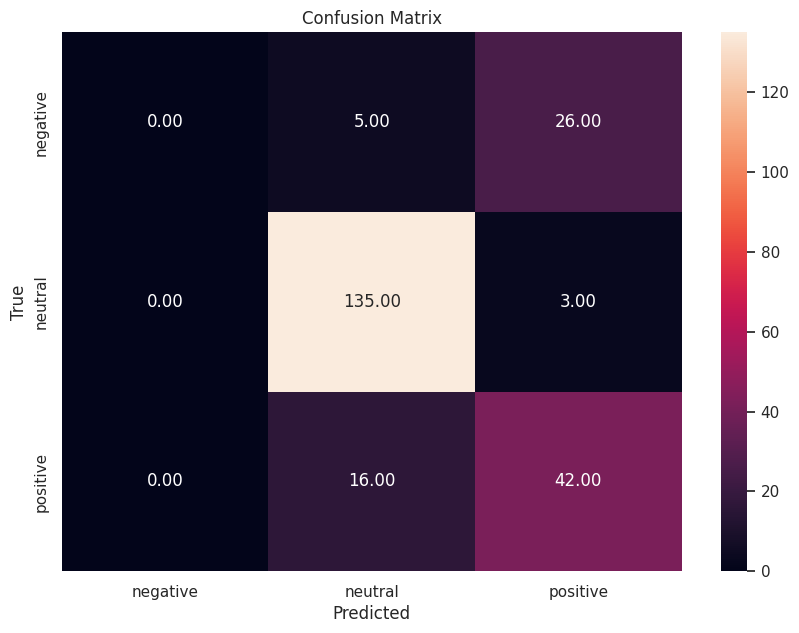

In [ ]:
score = evaluate_model(model, tokenized_X_test, y_test, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_head_only'
sub_dataset = 'All_agree'
train_size = len(y_train)
dataset_type = 'np_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model           distilbert-base-uncased
Fine Method         fine-tune_head_only
Sub-Dataset                   All_agree
Train Size                         1811
Dataset Type                 np_dataset
train loss                     0.488201
train acc                      0.770845
val loss                       0.533308
val acc                        0.769912
test loss                      0.483699
test acc                       0.779736
Name: 0, dtype: object

### Keeping the trained Classifier head of the first part: Fine-tune all the weights

#### Training the model

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


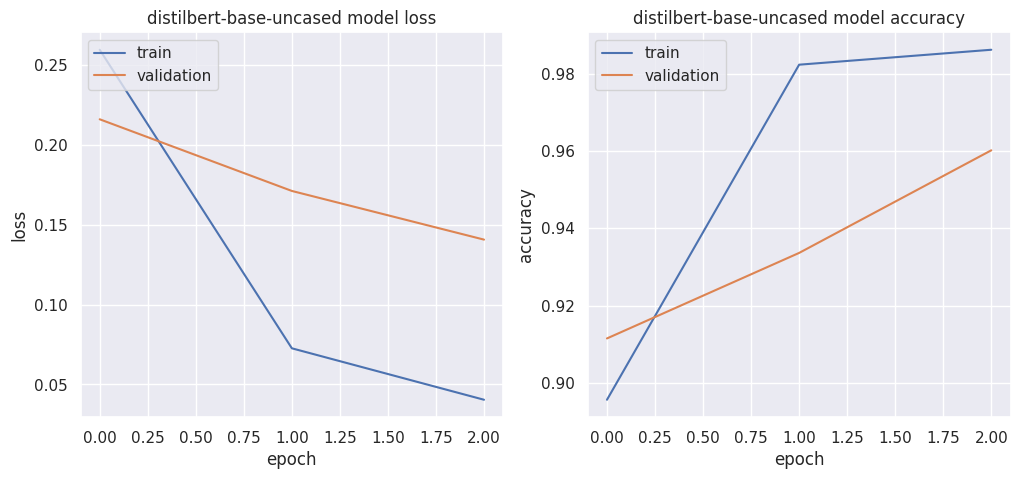

In [ ]:
model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()

num_train_steps = len(train_dataset['label']) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model(model_name, model, opt, (tokenized_X_train, y_train), (tokenized_X_validation, y_validation), batch_size, num_epochs)

#### Testing the model

              precision    recall  f1-score   support

           0      0.939     1.000     0.969        31
           1      0.993     0.978     0.985       138
           2      0.966     0.966     0.966        58

    accuracy                          0.978       227
   macro avg      0.966     0.981     0.973       227
weighted avg      0.978     0.978     0.978       227



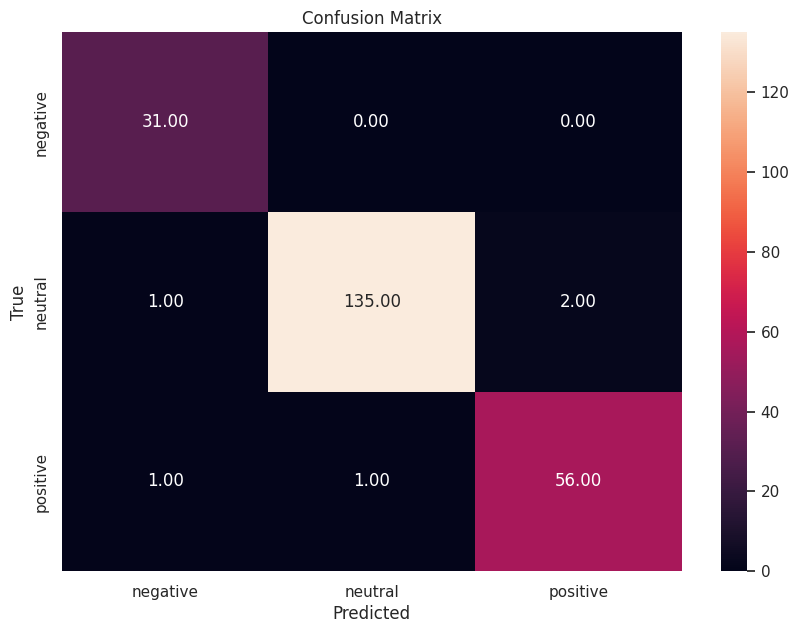

In [ ]:
score = evaluate_model(model, tokenized_X_test, y_test, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'Keep_head_fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(y_train)
dataset_type = 'np_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model                   distilbert-base-uncased
Fine Method     Keep_head_fine-tune_all_weights
Sub-Dataset                           All_agree
Train Size                                 1811
Dataset Type                         np_dataset
train loss                             0.021302
train acc                              0.994478
val loss                               0.140638
val acc                                0.960177
test loss                              0.077679
test acc                               0.977974
Name: 1, dtype: object

### Fine-tine all the weights (Pre-Trained + Classifier Head) simultaneously

#### Training the model after reloading the pre-trained model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


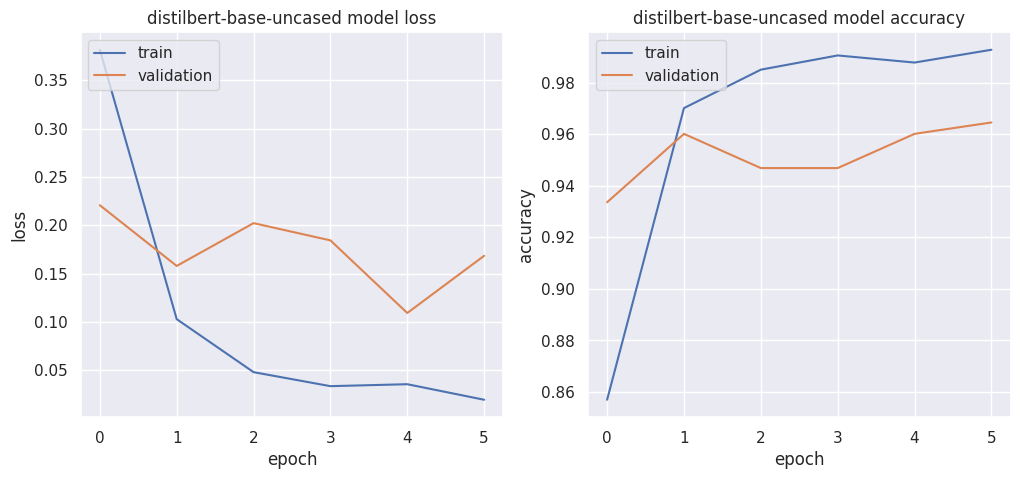

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

num_epochs = 6
num_train_steps = len(train_dataset['label']) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model(model_name, model, opt, (tokenized_X_train, y_train), (tokenized_X_validation, y_validation), batch_size, num_epochs)

#### Evaluating the model

              precision    recall  f1-score   support

           0      0.935     0.935     0.935        31
           1      0.951     0.993     0.972       138
           2      0.981     0.879     0.927        58

    accuracy                          0.956       227
   macro avg      0.956     0.936     0.945       227
weighted avg      0.957     0.956     0.955       227



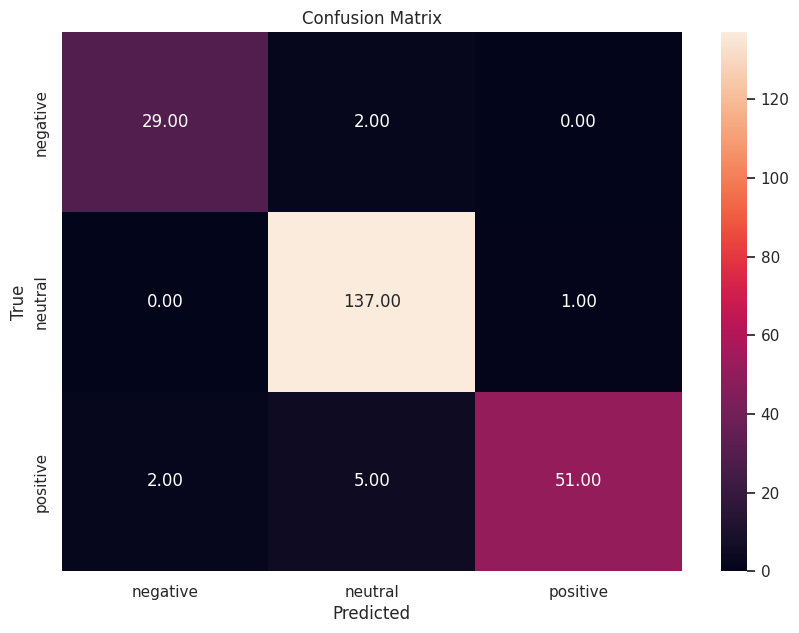

In [ ]:
score = evaluate_model(model, tokenized_X_test, y_test, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(y_train)
dataset_type = 'np_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model           distilbert-base-uncased
Fine Method       fine-tune_all_weights
Sub-Dataset                   All_agree
Train Size                         1811
Dataset Type                 np_dataset
train loss                     0.014163
train acc                       0.99503
val loss                       0.168488
val acc                        0.964602
test loss                      0.205284
test acc                       0.955947
Name: 2, dtype: object

When we fine-tine all the weights in the model, the results improve significantly. The measures of how well the model is performing - accuracy, precision, recall, and f1-score - on the test data are all above 90%. Also, there are fewer than 10 sentences in each category that are wrongly classified.

# Extra Part

## Create (and fit the model with) a TensorFlow Dataset (TFDS)

### Tokenization

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)
print("Tokenized Train Dataset:", tokenized_train_dataset)
print("Tokenized Validation Dataset:", tokenized_validation_dataset)
print("Tokenized Test Dataset:", tokenized_test_dataset)

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1811
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 226
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 227
})


Test the function of the data collator.

In [ ]:
# from transformers import DataCollatorWithPadding

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# samples = tokenized_train_dataset[:8]
# samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence"]}
# print([len(x) for x in samples["input_ids"]])

# batch = data_collator(samples)
# {k: v.shape for k, v in batch.items()}
# batch

### Make TensorFlow datasets

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Train a Model

#### Setting a model's parameters and optimizer

In [ ]:
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

#### Function for training a model with TensorFlow datasets

In [ ]:
def train_model_tfds(model_name, model, optimizer, train_data, validation_data, num_batch, num_epochs):

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
    )

    history = model.fit(
        train_data,
        validation_data=validation_data,
        batch_size=num_batch,
        callbacks=[early_stopping],
        epochs=num_epochs,
        verbose=0
    )

    plot_training_result(history,  model_name)

    train_score = model.evaluate(train_data, verbose=0)
    val_score = model.evaluate(validation_data, verbose=0)
    score = {'train_loss': train_score[0], 'train_accuracy': train_score[1],
             'val_loss': val_score[0], 'val_accuracy': val_score[1]}

    return model, score

#### Function for evaluating a model with TensorFlow datasets

In [ ]:
def evaluate_model_tfds(model, test_data, score):

    test_score = model.evaluate(test_data, verbose=0)
    score.update({'test_loss': test_score[0], 'test_accuracy': test_score[1]})
    print(score)

    # Predict the probabilities and labels
    predictions = model.predict(tf_test_dataset)["logits"]
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_dataset["label"]

    classification_summary = classification_report(true_labels, predicted_labels, digits=3, zero_division=0)
    print(classification_summary)

    label_class = ['negative','neutral','positive']
    confused_mat = confusion_matrix(true_labels, predicted_labels)
    sns.set()
    plt.figure(figsize=(10,7))
    sns.heatmap(confused_mat, annot=True, fmt=".2f", xticklabels=label_class, yticklabels=label_class)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return score

### Fine-tune only the Classifier head

Mistake: When training transformer models in Keras, using the default learning rate for the Adam optimizer (0.001) often leads to slow or erratic loss reduction. A much lower learning rate, like 0.00005, works better for these models. Additionally, gradually reducing the learning rate during training can be beneficial. This process, known as decaying or annealing the learning rate, can be achieved with a learning rate scheduler like PolynomialDecay. This scheduler linearly decreases the learning rate over time. To set it up correctly, we need to know the total number of training steps, which we calculate and pass to the scheduler.

In [ ]:
# # from tensorflow.keras import losses
# from tensorflow.keras.losses import SparseCategoricalCrossentropy

# model.compile(
#     optimizer="adam",
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )
# model.fit(
#     tf_train_dataset,
#     validation_data=tf_validation_dataset,
# )

#### Training the model

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


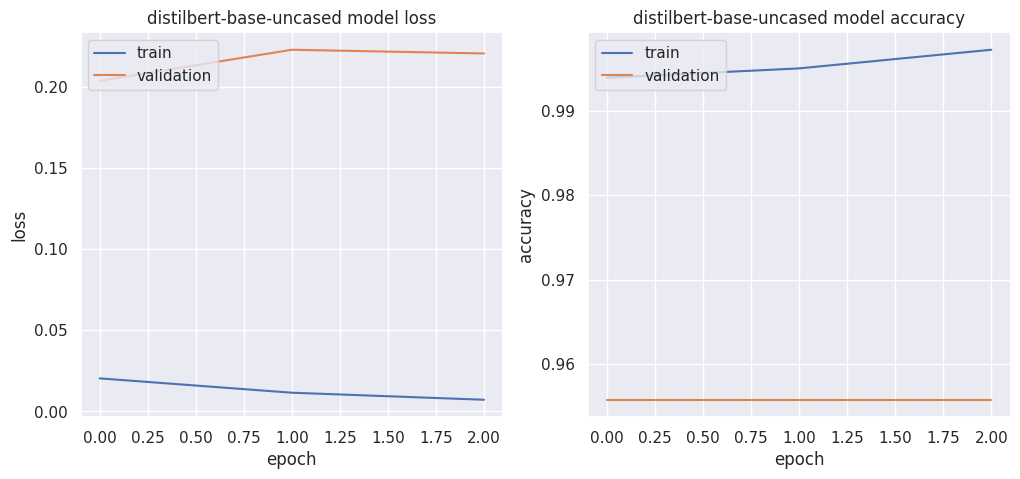

In [ ]:
model_name = "distilbert-base-uncased"
model.layers[0].trainable = False
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.00472300173714757, 'train_accuracy': 0.9988956451416016, 'val_loss': 0.22077308595180511, 'val_accuracy': 0.9557521939277649, 'test_loss': 0.18352428078651428, 'test_accuracy': 0.9647576808929443}
29/29 [==============================] - 5s 48ms/step
              precision    recall  f1-score   support

           0      0.161     0.161     0.161        31
           1      0.599     0.616     0.607       138
           2      0.222     0.207     0.214        58

    accuracy                          0.449       227
   macro avg      0.327     0.328     0.328       227
weighted avg      0.443     0.449     0.446       227



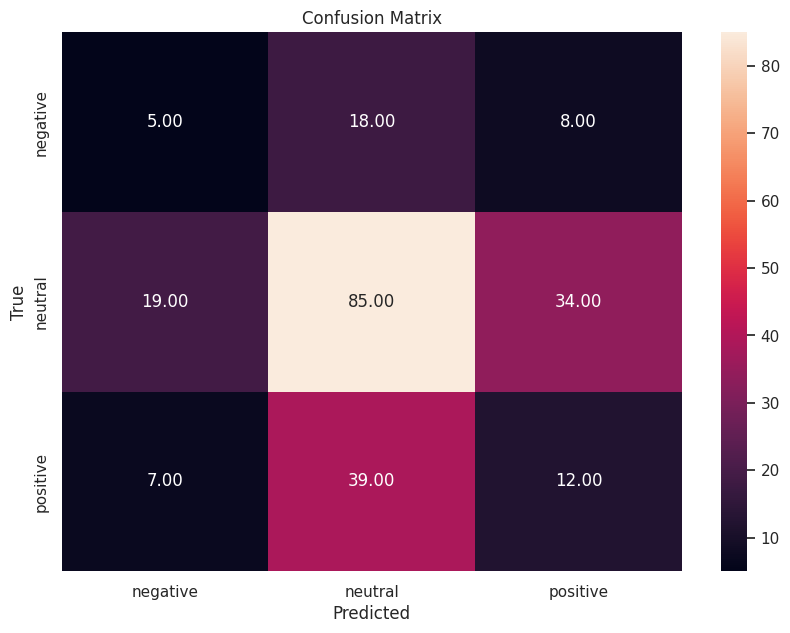

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_head_only'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model           distilbert-base-uncased
Fine Method         fine-tune_head_only
Sub-Dataset                   All_agree
Train Size                         1811
Dataset Type                 tf_dataset
train loss                     0.004723
train acc                      0.998896
val loss                       0.220773
val acc                        0.955752
test loss                      0.183524
test acc                       0.964758
Name: 3, dtype: object

### Keeping the trained Classifier head of the first part: Fine-tune all the weights

#### Training the model

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


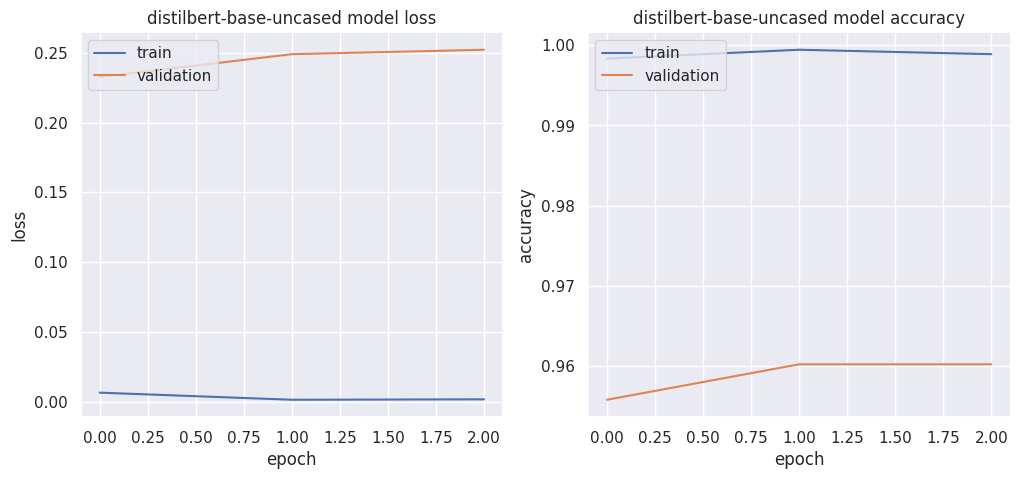

In [ ]:
model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.0003793961659539491, 'train_accuracy': 1.0, 'val_loss': 0.25224336981773376, 'val_accuracy': 0.9601770043373108, 'test_loss': 0.17445148527622223, 'test_accuracy': 0.9779735803604126}
29/29 [==============================] - 3s 33ms/step
              precision    recall  f1-score   support

           0      0.062     0.065     0.063        31
           1      0.601     0.601     0.601       138
           2      0.263     0.259     0.261        58

    accuracy                          0.441       227
   macro avg      0.309     0.308     0.309       227
weighted avg      0.441     0.441     0.441       227



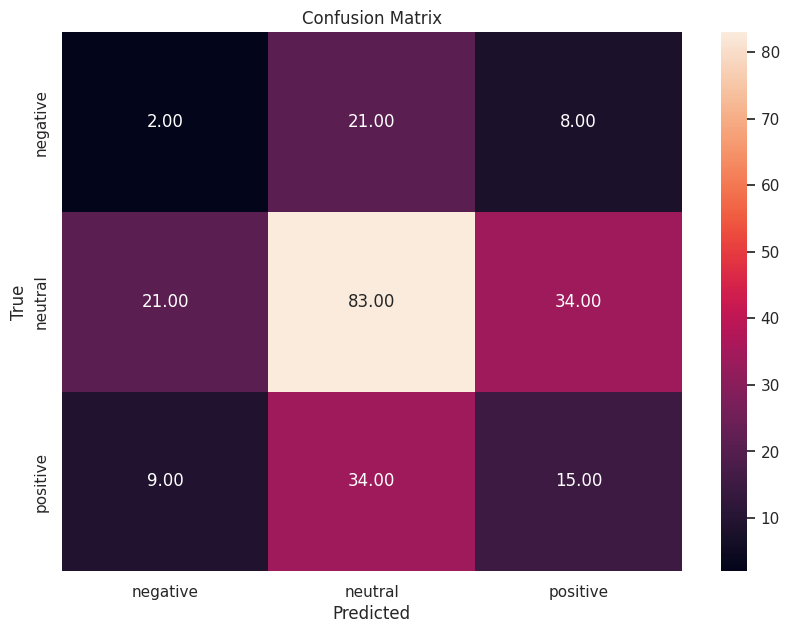

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'keep_head_fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model                   distilbert-base-uncased
Fine Method     keep_head_fine-tune_all_weights
Sub-Dataset                           All_agree
Train Size                                 1811
Dataset Type                         tf_dataset
train loss                             0.000379
train acc                                   1.0
val loss                               0.252243
val acc                                0.960177
test loss                              0.174451
test acc                               0.977974
Name: 4, dtype: object

### Fine-tine all the weights (Pre-Trained + Classifier Head) simultaneously

#### Training the model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


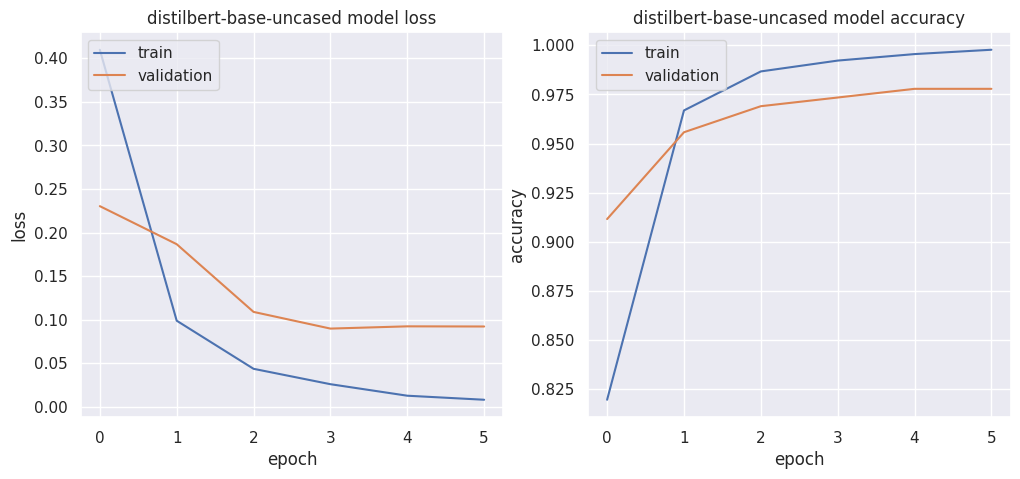

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.layers[3].trainable = True
model.summary()

num_epochs = 6
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.005247008986771107, 'train_accuracy': 0.9994478225708008, 'val_loss': 0.09234288334846497, 'val_accuracy': 0.9778761267662048, 'test_loss': 0.1086902990937233, 'test_accuracy': 0.9779735803604126}
29/29 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0      0.091     0.097     0.094        31
           1      0.574     0.565     0.569       138
           2      0.293     0.293     0.293        58

    accuracy                          0.432       227
   macro avg      0.319     0.318     0.319       227
weighted avg      0.436     0.432     0.434       227



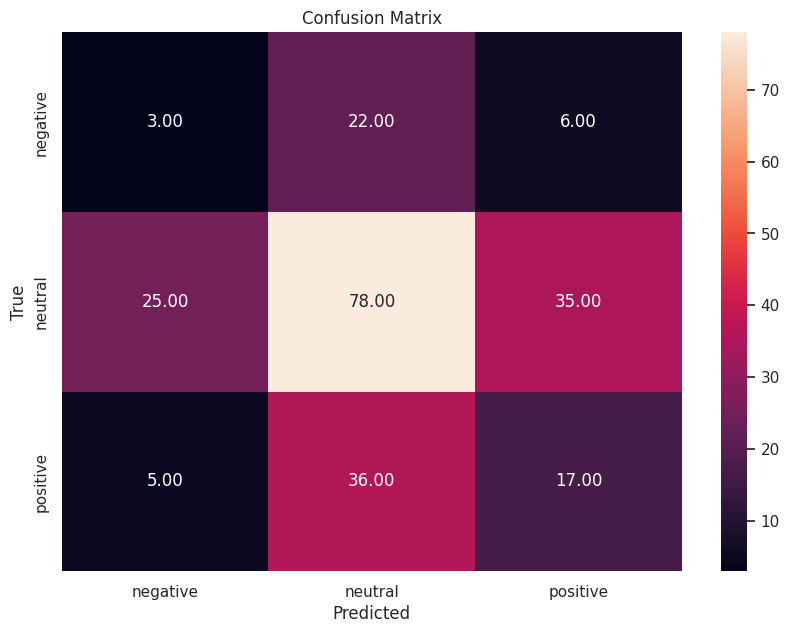

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model           distilbert-base-uncased
Fine Method       fine-tune_all_weights
Sub-Dataset                   All_agree
Train Size                         1811
Dataset Type                 tf_dataset
train loss                     0.005247
train acc                      0.999448
val loss                       0.092343
val acc                        0.977876
test loss                       0.10869
test acc                       0.977974
Name: 5, dtype: object

## Create my own Classification head

I used the same model as that I used in the basic part except for a classification head automatically provided with the HuggingFace model. As the model summary shown, it only includes the pre-trained part and doesn't have additional layers for classifying data.

In [ ]:
from transformers import TFDistilBertModel

transformer_model = TFDistilBertModel.from_pretrained(checkpoint)
transformer_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Customize a model

The following is my customized model, and its structure is

- Layer 1: the pre-trained model
- Layer 2: a pre-classification dense layer
- Layer 3: GlobalAveragePooling1D layer to reduce the data dimension
- Layer 4: a classification layer for 3 classes

In [ ]:
class custom_model(tf.keras.Model):

    def __init__(self, num_classes=3):
        super(custom_model, self).__init__()
        self.num_classes = num_classes

        self.transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dense = tf.keras.layers.Dense(128,activation='relu')
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        transformer = self.transformer_model(inputs)
        last_hidden_state = transformer[0]
        sequence_outputs = self.dense(last_hidden_state)
        x = self.pooling(sequence_outputs)
        return self.classifier(x)

### Training the model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarn

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_1 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 dense (Dense)               multiple                  98432     
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             multiple                  387       
                                                                 
Total params: 66461699 (253.53 MB)
Trainable params: 66461699 (253.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


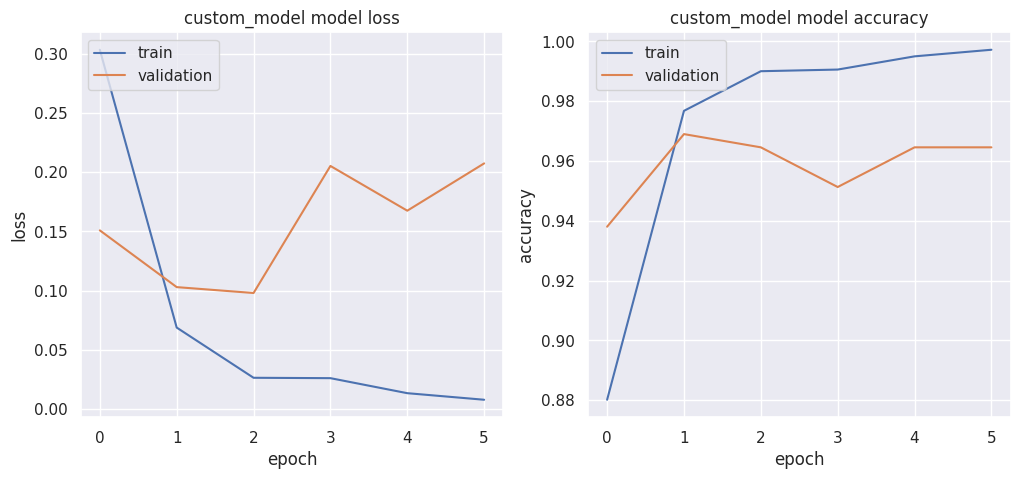

In [ ]:
num_epochs = 6
num_train_steps = len(train_dataset['label']) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)

model_name = 'custom_model'
model = custom_model()
model, score = train_model(model_name, model, opt, (tokenized_X_train, y_train), (tokenized_X_validation, y_validation), batch_size, num_epochs)
model.summary()

### Evaluate the model

              precision    recall  f1-score   support

           0      0.938     0.968     0.952        31
           1      0.993     0.986     0.989       138
           2      0.966     0.966     0.966        58

    accuracy                          0.978       227
   macro avg      0.965     0.973     0.969       227
weighted avg      0.978     0.978     0.978       227



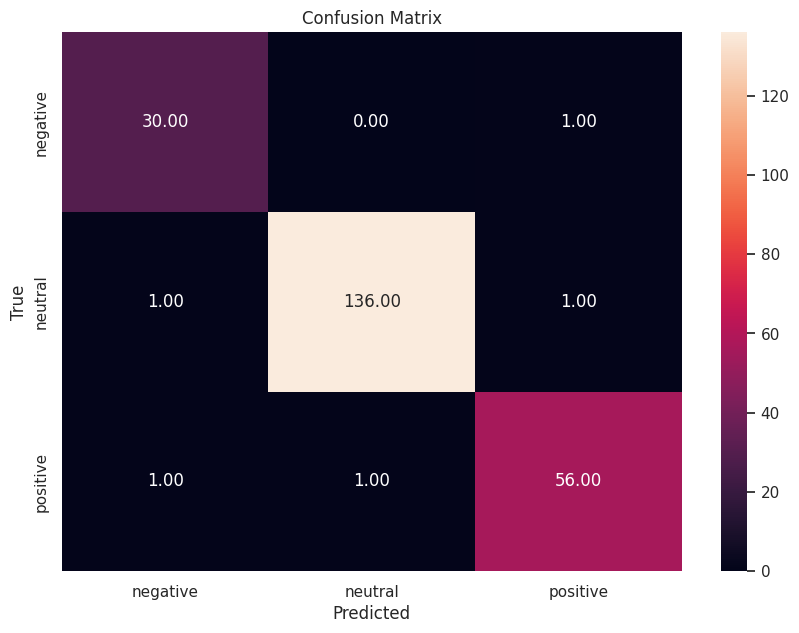

In [ ]:
score = evaluate_model(model, tokenized_X_test, y_test, score)

### Showing the model details and the result in the summary table

In [ ]:
model_name = 'custom_model'
fine_method = 'fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(y_train)
dataset_type = 'np_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model                    custom_model
Fine Method     fine-tune_all_weights
Sub-Dataset                 All_agree
Train Size                       1811
Dataset Type               np_dataset
train loss                   0.005032
train acc                    0.998343
val loss                     0.207583
val acc                      0.964602
test loss                    0.121531
test acc                     0.977974
Name: 6, dtype: object

## Use different "flavors" of the dataset

I separately used the datasets with "75% agreed", "66% agreed", and "50% agreed" to train the model with TensorFlow datasets. Then, I compared their performance with the model trained with the "all agreed" dataset.

In [ ]:
dataset_list = ['sentences_75agree', 'sentences_66agree', 'sentences_50agree']

### Get the training and evaluation results

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Map:   0%|          | 0/346 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2762
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 345
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 346
})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.007148314733058214, 'train_accuracy': 0.9985517859458923, 'val_loss': 0.3172459602355957, 'val_accuracy': 0.9246376752853394, 'test_loss': 0.2387891709804535, 'test_accuracy': 0.9479768872261047}
44/44 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

           0      0.909     0.930     0.920        43
           1      0.972     0.963     0.967       215
           2      0.910     0.920     0.915        88

    accuracy                          0.948       346
   macro avg      0.930     0.938     0.934       346
weighted avg      0.948     0.948     0.948       346



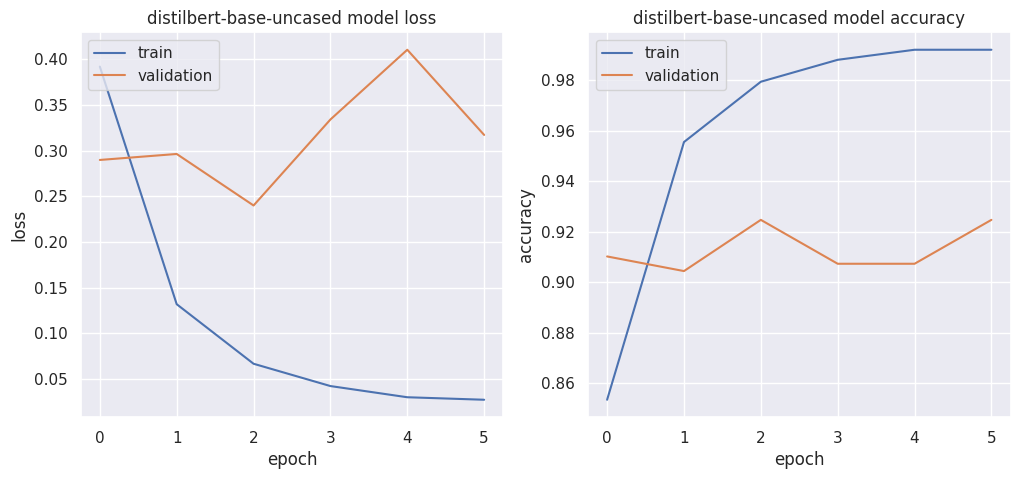

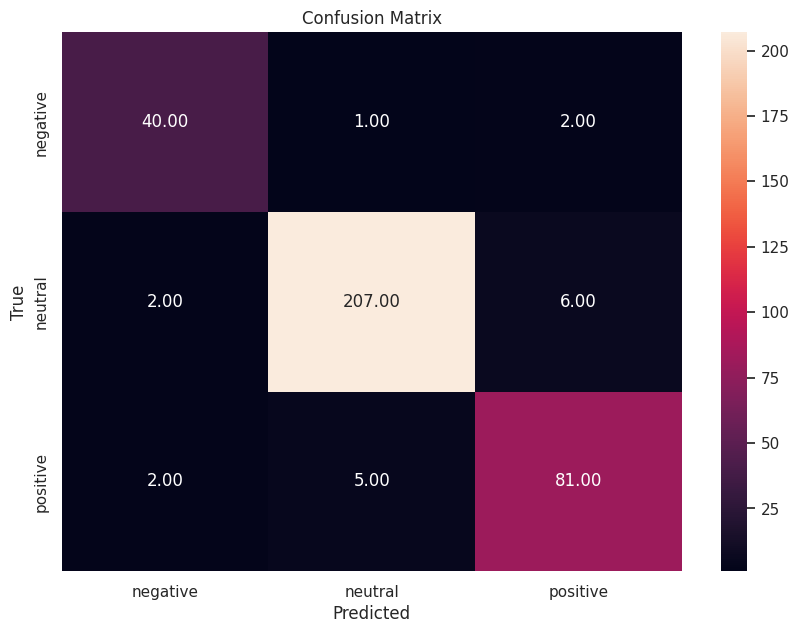

Model           distilbert-base-uncased
Fine Method       fine-tune_all_weights
Sub-Dataset           sentences_75agree
Train Size                          346
Dataset Type                 tf_dataset
train loss                     0.007148
train acc                      0.998552
val loss                       0.317246
val acc                        0.924638
test loss                      0.238789
test acc                       0.947977
Name: 7, dtype: object

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Map:   0%|          | 0/3373 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3373
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 422
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 422
})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.02199937216937542, 'train_accuracy': 0.992588222026825, 'val_loss': 0.4827117323875427, 'val_accuracy': 0.8696682453155518, 'test_loss': 0.4835279881954193, 'test_accuracy': 0.8601895570755005}
53/53 [==============================] - 5s 44ms/step
              precision    recall  f1-score   support

           0      0.766     0.783     0.774        46
           1      0.917     0.858     0.887       246
           2      0.800     0.892     0.844       130

    accuracy                          0.860       422
   macro avg      0.828     0.844     0.835       422
weighted avg      0.865     0.860     0.861       422



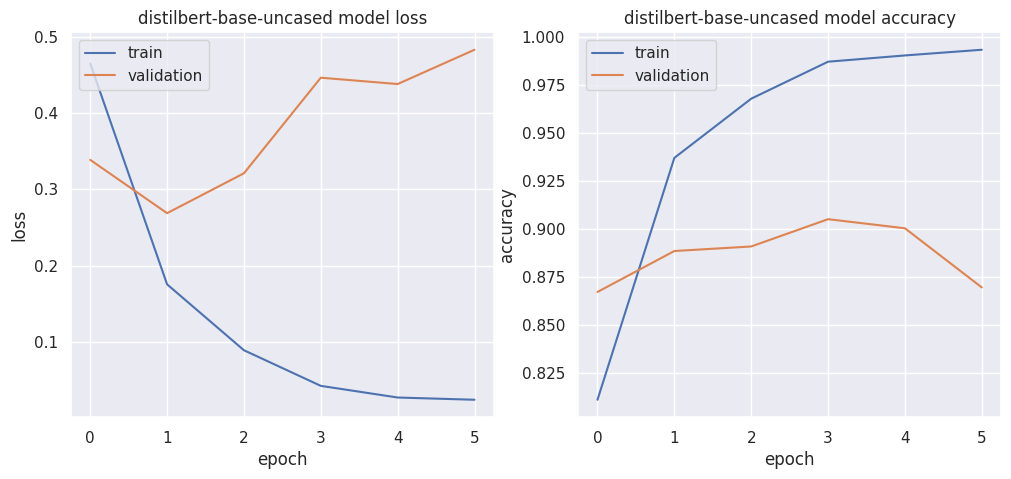

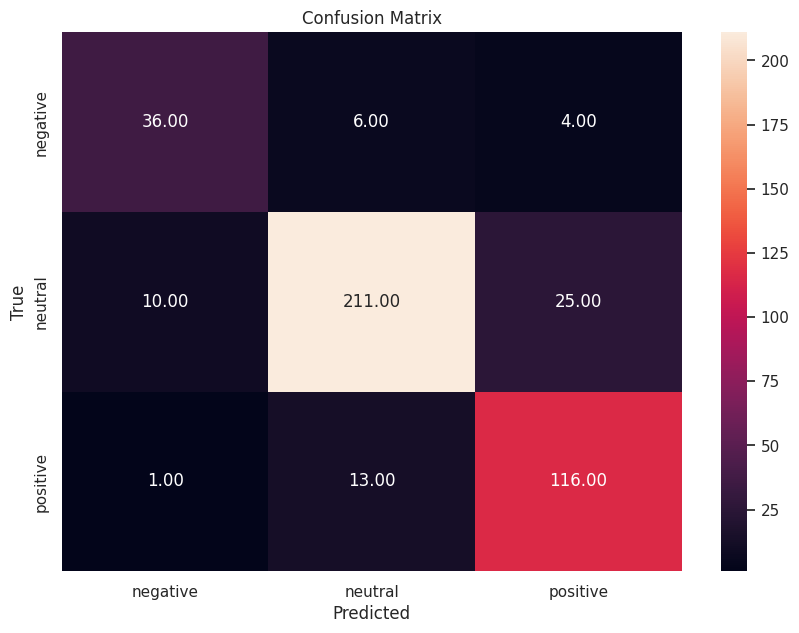

Model           distilbert-base-uncased
Fine Method       fine-tune_all_weights
Sub-Dataset           sentences_66agree
Train Size                          422
Dataset Type                 tf_dataset
train loss                     0.021999
train acc                      0.992588
val loss                       0.482712
val acc                        0.869668
test loss                      0.483528
test acc                        0.86019
Name: 8, dtype: object

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3876
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 485
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 485
})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.24463467299938202, 'train_accuracy': 0.9153766632080078, 'val_loss': 0.39085277915000916, 'val_accuracy': 0.830927848815918, 'test_loss': 0.4280279874801636, 'test_accuracy': 0.8226804137229919}
61/61 [==============================] - 5s 41ms/step
              precision    recall  f1-score   support

           0      0.724     0.859     0.786        64
           1      0.872     0.843     0.857       274
           2      0.785     0.769     0.777       147

    accuracy                          0.823       485
   macro avg      0.793     0.824     0.806       485
weighted avg      0.826     0.823     0.823       485



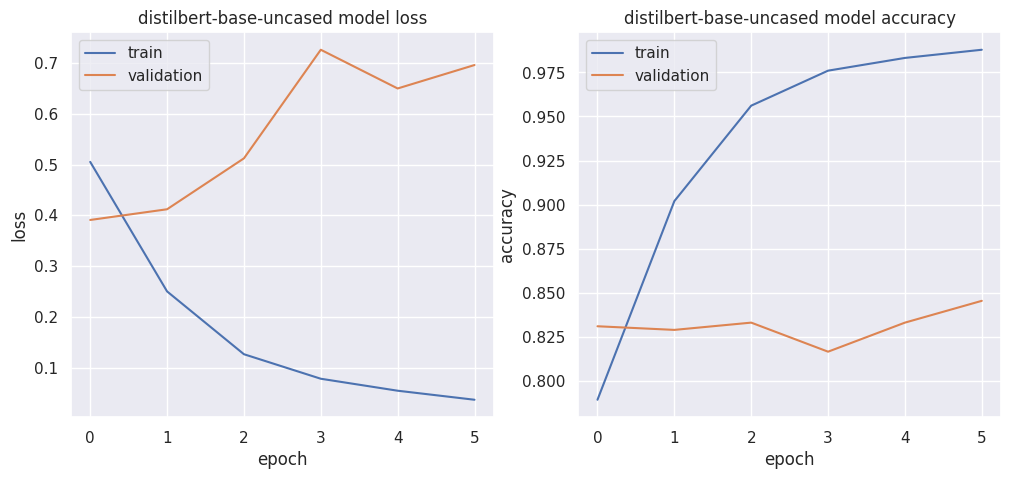

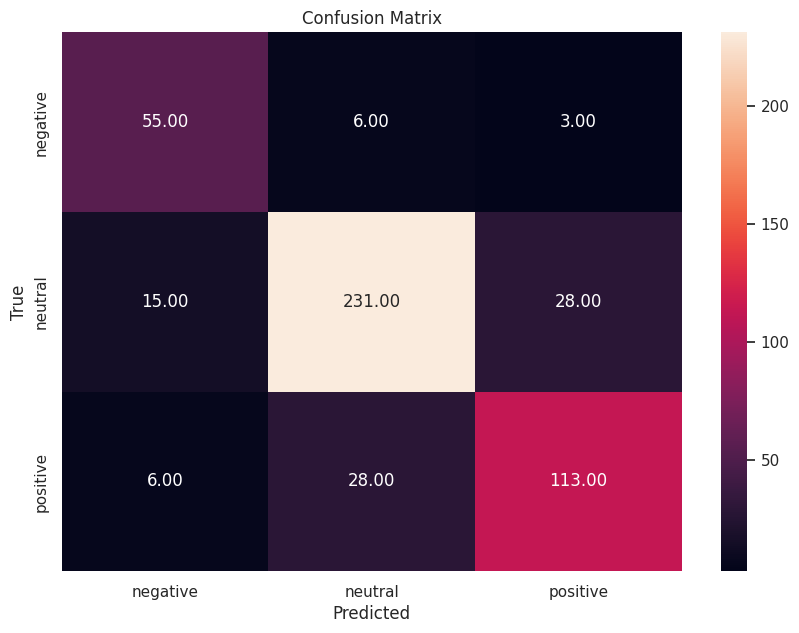

Model           distilbert-base-uncased
Fine Method       fine-tune_all_weights
Sub-Dataset           sentences_50agree
Train Size                          485
Dataset Type                 tf_dataset
train loss                     0.244635
train acc                      0.915377
val loss                       0.390853
val acc                        0.830928
test loss                      0.428028
test acc                        0.82268
Name: 9, dtype: object

In [ ]:
for i, subset in enumerate(dataset_list):
    raw_datasets = load_dataset('financial_phrasebank', subset, split="train")
    train_test_split = raw_datasets.train_test_split(test_size=0.2)
    train_dataset = train_test_split['train']
    test_dataset = train_test_split['test']
    validation_test_split = test_dataset.train_test_split(test_size=0.5)
    validation_dataset = validation_test_split['train']
    test_dataset = validation_test_split['test']

    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize(batch):
        return tokenizer(batch['sentence'], padding=True, truncation=True)
    # Apply the tokenizer to the training dataset
    tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
    tokenized_validation_dataset = validation_dataset.map(tokenize, batched=True)
    tokenized_test_dataset = test_dataset.map(tokenize, batched=True)
    print("Tokenized Train Dataset:", tokenized_train_dataset)
    print("Tokenized Validation Dataset:", tokenized_validation_dataset)
    print("Tokenized Test Dataset:", tokenized_test_dataset)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
    tf_train_dataset = tokenized_train_dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=8,
    )

    tf_validation_dataset = tokenized_validation_dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=8,
    )

    tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols=['label'],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=8,
    )

    num_epochs = 6
    num_train_steps = len(train_dataset['label']) * num_epochs
    lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
    opt = Adam(learning_rate=lr_scheduler)

    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

    model_name = 'distilbert-base-uncased'
    fine_method = 'fine-tune_all_weights'
    sub_dataset = subset
    train_size = len(tf_train_dataset)
    dataset_type = 'tf_dataset'

    # model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
    # save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
    score = evaluate_model_tfds(model, tf_test_dataset, score)
    summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)

    display(summary_table.iloc[-1,:])

### Compare the results of the model trained with four different datasets

In [ ]:
display(summary_table.iloc[[5,-3,-2,-1],:])

,Model,Fine Method,Sub-Dataset,Train Size,Dataset Type,train loss,train acc,val loss,val acc,test loss,test acc
5,distilbert-base-uncased,fine-tune_all_weights,All_agree,1811,tf_dataset,0.005247,0.999448,0.092343,0.977876,0.108690,0.977974
7,distilbert-base-uncased,fine-tune_all_weights,sentences_75agree,346,tf_dataset,0.007148,0.998552,0.317246,0.924638,0.238789,0.947977
8,distilbert-base-uncased,fine-tune_all_weights,sentences_66agree,422,tf_dataset,0.021999,0.992588,0.482712,0.869668,0.483528,0.860190
9,distilbert-base-uncased,fine-tune_all_weights,sentences_50agree,485,tf_dataset,0.244635,0.915377,0.390853,0.830928,0.428028,0.822680


According to the above table and graph:

- Based on the accuracy, precision, recall, and f1 score, the model performance: "all agreed" > "75% agree" > "66% agree" > "50% agree"
  - "all agreed" accuracy range: 0.92-0.975
  - "75% agree" accuracy range: 0.915-0.925
  - "66% agree" accuracy range: 0.87-0.91
  - "50% agree" accuracy range: 0.82-0.845

- The sentences might be confusing because it mixes different feelings or doesn't have a clear emotion to identify. This can make it hard for both people and machines to agree on what the sentiment is.

## Address any Imbalanced Data issues

Here I addressed the imbalanced data issues for dataset that all annotators agreed.

### Get the dataset that all annotators agreed

In [ ]:
raw_datasets = load_dataset('financial_phrasebank','sentences_allagree', split="train")

train_test_split = raw_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']
validation_test_split = test_dataset.train_test_split(test_size=0.5)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

### Balance the data set so that the three labels have the same amount of data

In [ ]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_res, y_res = ros.fit_resample(np.array(train_dataset['sentence']).reshape(-1,1), train_dataset['label'])

In [ ]:
label_class = ['negative','neutral','positive']
for i, label in enumerate(label_class):
    print(' Number of sentences in the ' + label + ' class: ', np.sum(np.array(y_res)==i))

 Number of sentences in the negative class:  1116
 Number of sentences in the neutral class:  1116
 Number of sentences in the positive class:  1116


### Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
transformer_model = TFDistilBertModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X_res_list = list(map(lambda x: x[0], X_res))

In [ ]:
tokenized_X_train = tokenizer(X_res_list, padding=True, return_tensors="np", truncation=True, max_length=150)
tokenized_X_validation = tokenizer(validation_dataset['sentence'], padding=True, return_tensors="np", truncation=True, max_length=150)
tokenized_X_test = tokenizer(test_dataset['sentence'], padding=True, return_tensors="np", truncation=True, max_length=150)

tokenized_X_train = dict(tokenized_X_train)
tokenized_X_validation = dict(tokenized_X_validation)
tokenized_X_test = dict(tokenized_X_test)

In [ ]:
y_train = np.array(y_res)
y_validation = np.array(validation_dataset['label'])
y_test = np.array(test_dataset['label'])

### Training the model

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarn

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_3 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 dense_2 (Dense)             multiple                  98432     
                                                                 
 global_average_pooling1d_1  multiple                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             multiple                  387       
                                                                 
Total params: 66461699 (253.53 MB)
Trainable params: 66461699 (253.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


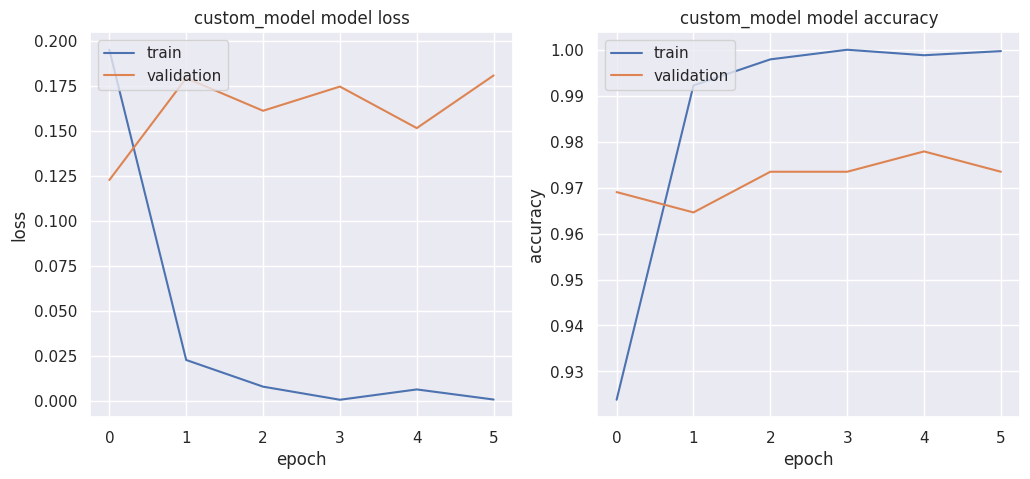

In [ ]:
num_epochs = 6
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)

model_name = 'custom_model'
model = custom_model()
model, score = train_model(model_name, model, opt, (tokenized_X_train, y_train), (tokenized_X_validation, y_validation), batch_size, num_epochs)
model.summary()

### Evaluating the model

              precision    recall  f1-score   support

           0      0.931     0.900     0.915        30
           1      0.993     1.000     0.996       134
           2      0.952     0.952     0.952        63

    accuracy                          0.974       227
   macro avg      0.959     0.951     0.955       227
weighted avg      0.973     0.974     0.973       227



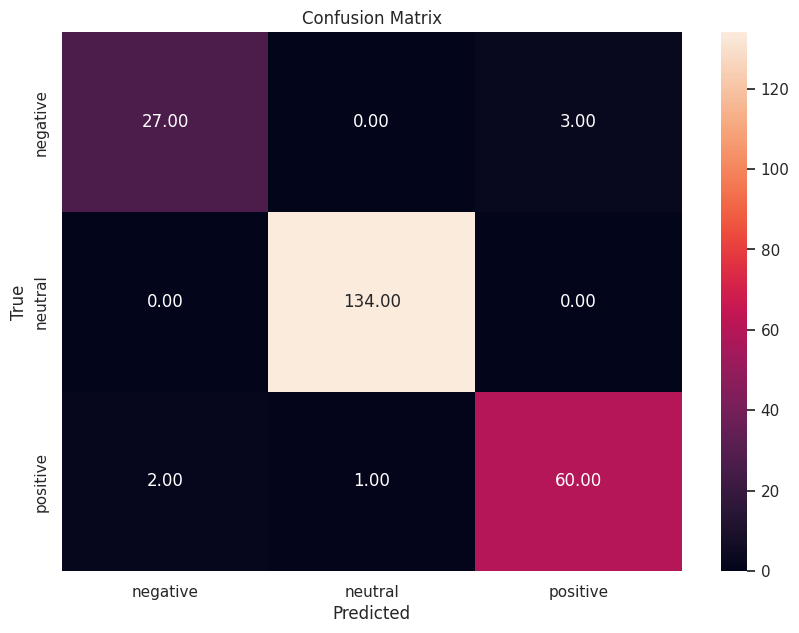

In [ ]:
score = evaluate_model(model, tokenized_X_test, y_test, score)

### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine_tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(y_train)
dataset_type = 'np_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model                    custom_model
Fine Method     fine_tune_all_weights
Sub-Dataset                 all agree
Train Size                       3348
Dataset Type               np_dataset
train loss                   0.023934
train acc                    0.993429
val loss                     0.122879
val acc                      0.969027
test loss                    0.083016
test acc                     0.973568
Name: 10, dtype: object

### Compare a model trained using an imbalanced dataset to a model trained using a balanced dataset

In [ ]:
display(summary_table.iloc[[6, -1],:])

,Model,Fine Method,Sub-Dataset,Train Size,Dataset Type,train loss,train acc,val loss,val acc,test loss,test acc
6,custom_model,fine-tune_all_weights,All_agree,1811,np_dataset,0.005032,0.998343,0.207583,0.964602,0.121531,0.977974
10,custom_model,fine_tune_all_weights,all agree,3348,np_dataset,0.023934,0.993429,0.122879,0.969027,0.083016,0.973568


The performance improved a bit, compared to that in the basic part.

- accuracy: balanced 0.974 ; imbalanced 0.978
- precision: balanced 0.993 ; imbalanced 0.993
- recall: balanced 1.000 ; imbalanced 0.986
- f1 score: balanced 0.996 ; imbalanced 0.989

Training a model with balanced or imbalance data has a similar performance.

## Superior Error Analysis

In [ ]:
y_test_pred = model.predict(tokenized_X_test)
condition = (np.array(test_dataset['label']) != (np.argmax(y_test_pred, axis=1)))
error_sentence = np.array(test_dataset['sentence'])[condition]
error_true_label = np.array(test_dataset['label'])[condition]
error_pred_label = np.argmax(y_test_pred, axis=1)[condition]
error_analysis = pd.DataFrame([error_sentence, error_true_label, error_pred_label]).T
error_analysis.columns=['Sentence', 'True Label', 'Predicted Label']

8/8 [==============================] - 1s 95ms/step


In [ ]:
pd.set_option('display.max_colwidth', None)

display(error_analysis[error_analysis['True Label']==0])
display(error_analysis[error_analysis['True Label']==1])
display(error_analysis[error_analysis['True Label']==2])

,Sentence,True Label,Predicted Label
2,Finnish business software group AffectoGenimap Oyj said its net profit halved to 1.2 mln euro ( $ 1.5 mln ) in the first nine months of 2006 from 2.2 mln euro ( $ 2.8 mln ) in the same period of 2005 .,0,2
4,"Frost sold shares for $ 19 million at $ 6.06-7 .12 per share , compared with Friday 's high of $ 11.33 and low of $ 10.14 .",0,2
5,11 August 2010 - Finnish measuring equipment maker Vaisala Oyj HEL : VAIAS said today that its net loss widened to EUR4 .8 m in the first half of 2010 from EUR2 .3 m in the corresponding period a year earlier .,0,2


,Sentence,True Label,Predicted Label


,Sentence,True Label,Predicted Label
0,The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 .,2,0
1,These moderate but significant changes resulted in a significant 24-32 % reduction in the estimated CVD risk .,2,0
3,"Raisio 's bid to buy Glisten is a `` win-win '' deal for both companies , the chairman of the UK snacks firm told just-food today 10 February .",2,1


The table indicates that there are more cases of positive sentences being incorrectly classified. This seems to happen for two main reasons:

1. Misclassification as Negative: Some positive sentences are wrongly labeled as negative. This often occurs when these sentences contain negative words. However, in these cases, there is usually another negative word that changes the overall meaning, making the sentence actually positive.
2. Misclassification as Neutral: Other positive sentences are incorrectly identified as neutral. This is typically because certain words that carry a positive meaning are not recognized as such by the model. Examples of such words include "manages well", "satisfied", and "convenient".

## Experiment with different Pre-Trained models

Here I chose "bert-base-uncased" as the bigger pre-trained model, and I compared its performance with the "distilbert-base-uncased" model.

Model structure comparison (with the classifier head):
- "distilbert-base-uncased":
  - 66,955,779 parameters
  - 4 layers: Distilbert + Dense + Dense + Dropout
- "bert-base-uncased":
  - 109,484,547 parameters
  - 3 layers: Bert + Dropout + Dense

In [ ]:
train_test_split = raw_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']
validation_test_split = test_dataset.train_test_split(test_size=0.5)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

### Tokenization

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

# Apply the tokenizer to the training dataset
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)
print("Tokenized Train Dataset:", tokenized_train_dataset)
print("Tokenized Validation Dataset:", tokenized_validation_dataset)
print("Tokenized Test Dataset:", tokenized_test_dataset)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1811
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 226
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 227
})


### Fine-tune only the Classifier head

#### Training the model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_253 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


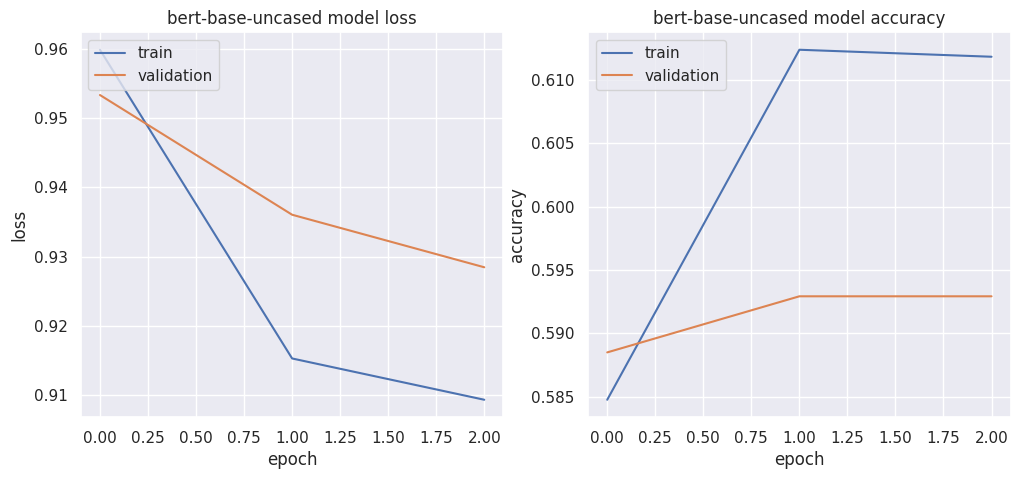

In [ ]:
model_name = "bert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.layers[0].trainable = False
model.layers[1].trainable = True
model.layers[2].trainable = True
model.summary()

num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.8969477415084839, 'train_accuracy': 0.6129210591316223, 'val_loss': 0.9284729361534119, 'val_accuracy': 0.5929203629493713, 'test_loss': 0.8623650670051575, 'test_accuracy': 0.6431717872619629}
29/29 [==============================] - 6s 59ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        27
           1      0.643     1.000     0.783       146
           2      0.000     0.000     0.000        54

    accuracy                          0.643       227
   macro avg      0.214     0.333     0.261       227
weighted avg      0.414     0.643     0.504       227



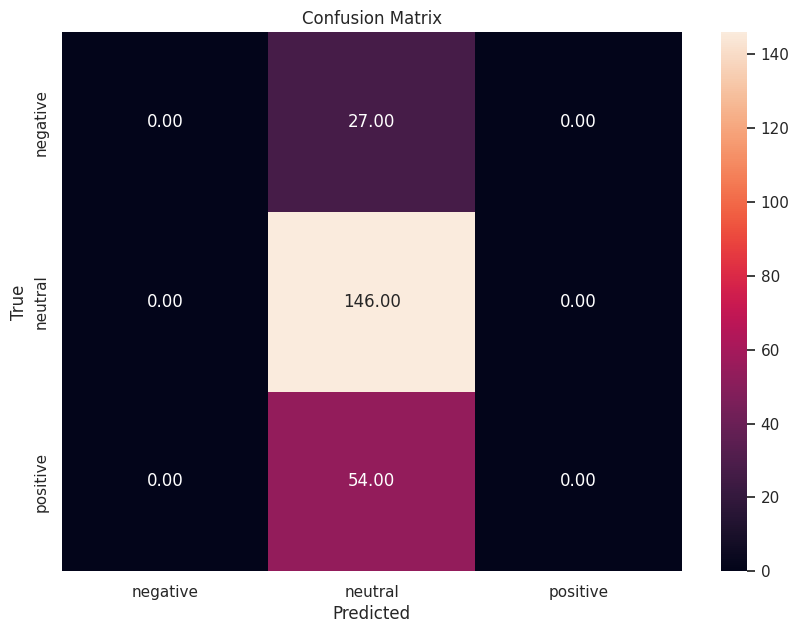

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_head_only'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model             bert-base-uncased
Fine Method     fine-tune_head_only
Sub-Dataset               All_agree
Train Size                     1811
Dataset Type             tf_dataset
train loss                 0.896948
train acc                  0.612921
val loss                   0.928473
val acc                     0.59292
test loss                  0.862365
test acc                   0.643172
Name: 11, dtype: object

### Keeping the trained Classifier head of the first part: Fine-tune all the weights

#### Training the model

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_253 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


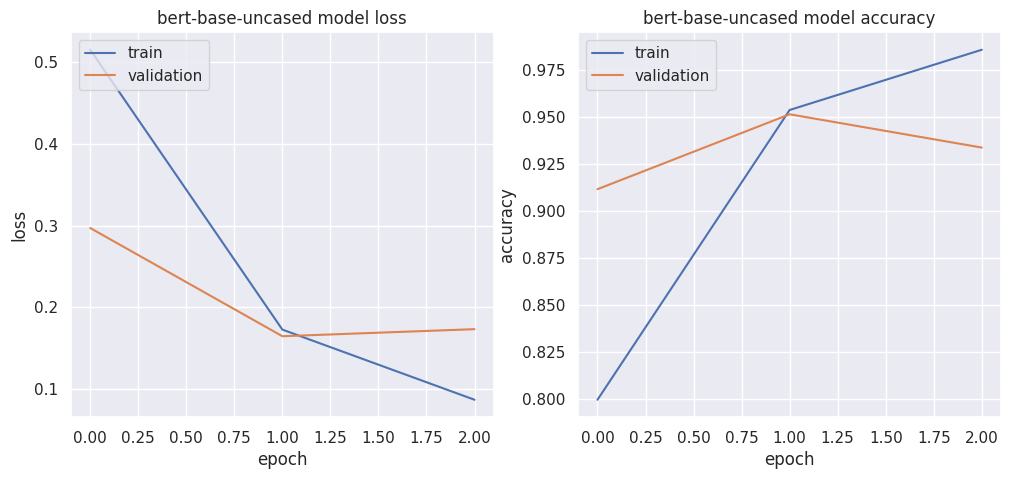

In [ ]:
model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.summary()

num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.06080242246389389, 'train_accuracy': 0.9911651015281677, 'val_loss': 0.1732695996761322, 'val_accuracy': 0.9336283206939697, 'test_loss': 0.12206564843654633, 'test_accuracy': 0.9691630005836487}
29/29 [==============================] - 5s 73ms/step
              precision    recall  f1-score   support

           0      0.067     0.074     0.070        27
           1      0.636     0.623     0.630       146
           2      0.167     0.167     0.167        54

    accuracy                          0.449       227
   macro avg      0.290     0.288     0.289       227
weighted avg      0.457     0.449     0.453       227



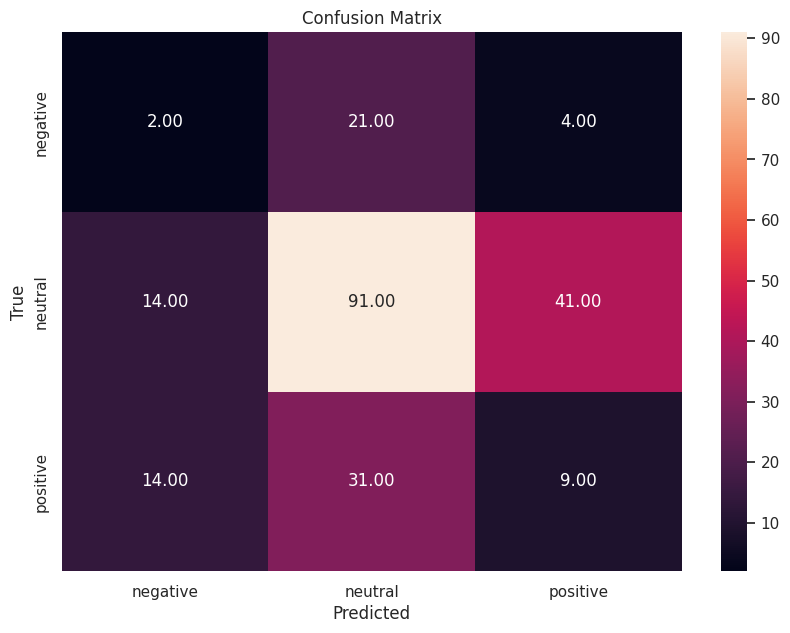

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'keep_head_fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model                         bert-base-uncased
Fine Method     keep_head_fine-tune_all_weights
Sub-Dataset                           All_agree
Train Size                                 1811
Dataset Type                         tf_dataset
train loss                             0.060802
train acc                              0.991165
val loss                                0.17327
val acc                                0.933628
test loss                              0.122066
test acc                               0.969163
Name: 12, dtype: object

### Fine-tine all the weights (Pre-Trained + Classifier Head) simultaneously

#### Training the model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_291 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


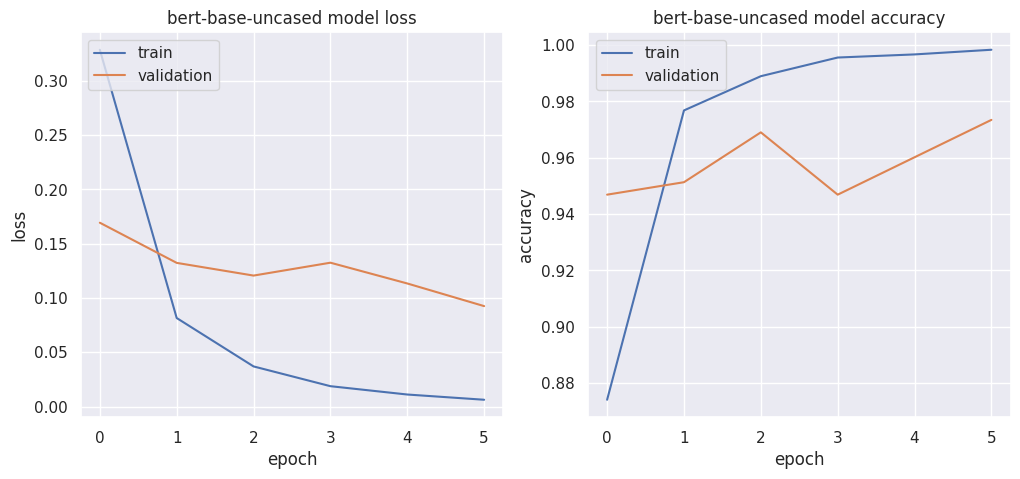

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[2].trainable = True
model.summary()

num_epochs = 6
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = Adam(learning_rate=lr_scheduler)
opt.build(model.trainable_variables)

model, score = train_model_tfds(model_name, model, opt, tf_train_dataset, tf_validation_dataset, batch_size, num_epochs)

#### Evaluating the model

{'train_loss': 0.0036343694664537907, 'train_accuracy': 0.9994478225708008, 'val_loss': 0.0925113633275032, 'val_accuracy': 0.9734513163566589, 'test_loss': 0.11184664070606232, 'test_accuracy': 0.9823788404464722}
29/29 [==============================] - 7s 60ms/step
              precision    recall  f1-score   support

           0      0.033     0.037     0.035        27
           1      0.630     0.630     0.630       146
           2      0.235     0.222     0.229        54

    accuracy                          0.463       227
   macro avg      0.300     0.296     0.298       227
weighted avg      0.465     0.463     0.464       227



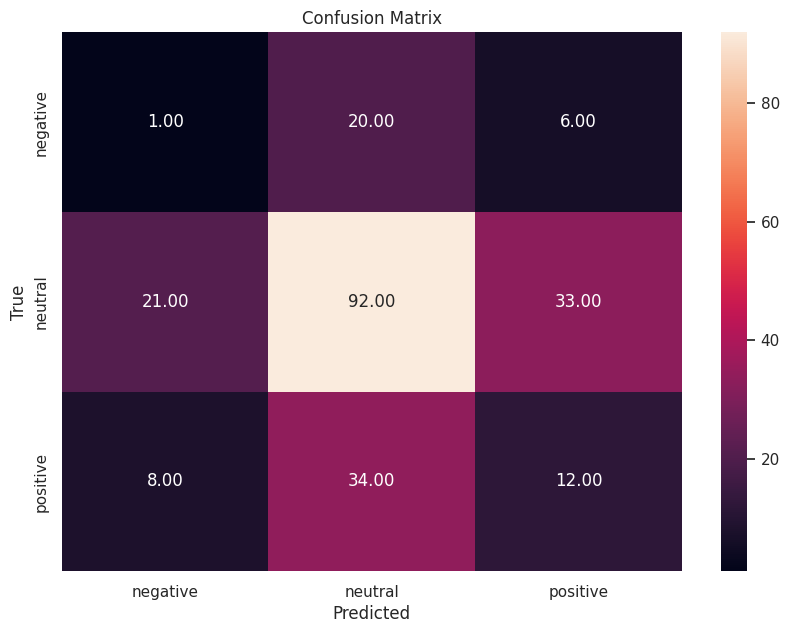

In [ ]:
score = evaluate_model_tfds(model, tf_test_dataset, score)

#### Showing the model details and the result in the summary table

In [ ]:
fine_method = 'fine-tune_all_weights'
sub_dataset = 'All_agree'
train_size = len(train_dataset['label'])
dataset_type = 'tf_dataset'

# model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
# save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
display(summary_table.iloc[-1,:])

Model               bert-base-uncased
Fine Method     fine-tune_all_weights
Sub-Dataset                 All_agree
Train Size                       1811
Dataset Type               tf_dataset
train loss                   0.003634
train acc                    0.999448
val loss                     0.092511
val acc                      0.973451
test loss                    0.111847
test acc                     0.982379
Name: 13, dtype: object

#### Compare the results

In [ ]:
display(summary_table.iloc[[3,4,5,-3,-2,-1],:])

,Model,Fine Method,Sub-Dataset,Train Size,Dataset Type,train loss,train acc,val loss,val acc,test loss,test acc
3,distilbert-base-uncased,fine-tune_head_only,All_agree,1811,tf_dataset,0.004723,0.998896,0.220773,0.955752,0.183524,0.964758
4,distilbert-base-uncased,keep_head_fine-tune_all_weights,All_agree,1811,tf_dataset,0.000379,1.000000,0.252243,0.960177,0.174451,0.977974
5,distilbert-base-uncased,fine-tune_all_weights,All_agree,1811,tf_dataset,0.005247,0.999448,0.092343,0.977876,0.108690,0.977974
11,bert-base-uncased,fine-tune_head_only,All_agree,1811,tf_dataset,0.896948,0.612921,0.928473,0.592920,0.862365,0.643172
12,bert-base-uncased,keep_head_fine-tune_all_weights,All_agree,1811,tf_dataset,0.060802,0.991165,0.173270,0.933628,0.122066,0.969163
13,bert-base-uncased,fine-tune_all_weights,All_agree,1811,tf_dataset,0.003634,0.999448,0.092511,0.973451,0.111847,0.982379


- "distilbert-base-uncased" v.s. "bert-base-uncased" (Fine-tune only the Classifier head)
  - accuracy: 0.95 > 0.593
  - precision: 0.599 < 0643
  - recall: 0.616 < 1.000
  - f1 score: 0.607 > 0.783
- "distilbert-base-uncased" v.s. "bert-base-uncased" (Keeping the trained Classifier head of the first part: Fine-tune all the weights)
  - accuracy: 0.96 > 0.95
  - precision: 0.601 < 0.636
  - recall: 0.601 < 0.623
  - f1 score: 0.601 < 0.630
- "distilbert-base-uncased" v.s. "bert-base-uncased" (Fine-tine all the weights simultaneously)
  - accuracy: 0.975 = 0.975
  - precision: 0.574 < 0.630
  - recall: 0.565 < 0.630
  - f1 score: 0.569 < 0.630

When only fine-tuning the head, the smaller model performs better than the bigger model in terms of accuracy. In the second and third way, the bigger model performs slightly better, but their difference is not that much.

In conclusion, a bigger model may not lead to better performance but cost more computation capacity. When choosing a model, we should focus more on quality, not quantity.

## Experiment with Fine-Tuning

I used the "distilbert-base-uncased" model to do the experiment. I randomly selected 100 data, 500 data, and 1000 data to train the model. Then, I compared their results to the model which was trained with 1811 data.

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# train_test_split = raw_datasets.train_test_split(test_size=0.2)
# train_dataset = train_test_split['train']
# test_dataset = train_test_split['test']
# validation_test_split = test_dataset.train_test_split(test_size=0.5)
# validation_dataset = validation_test_split['train']
# test_dataset = validation_test_split['test']
# print("Train Dataset:", train_dataset)
# print("Validation Dataset:", validation_dataset)
# print("Test Dataset:", test_dataset)

def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

# Apply the tokenizer to the training dataset
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)
print("Tokenized Train Dataset:", tokenized_train_dataset)
print("Tokenized Validation Dataset:", tokenized_validation_dataset)
print("Tokenized Test Dataset:", tokenized_test_dataset)

tokenized_train_dataset_100 = tokenized_train_dataset.select(random.sample(range(len(tokenized_train_dataset)), 100))#.take(100).prefetch(tf.data.AUTOTUNE)
tokenized_train_dataset_500 = tokenized_train_dataset.select(random.sample(range(len(tokenized_train_dataset)), 500))#.take(500).prefetch(tf.data.AUTOTUNE)
tokenized_train_dataset_1000 = tokenized_train_dataset.select(random.sample(range(len(tokenized_train_dataset)), 1000))#.take(1000).prefetch(tf.data.AUTOTUNE)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset_100 = tokenized_train_dataset_100.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_train_dataset_500 = tokenized_train_dataset_500.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_train_dataset_1000 = tokenized_train_dataset_1000.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['label'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:399: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Tokenized Train Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1811
})
Tokenized Validation Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 226
})
Tokenized Test Dataset: Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 227
})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.3359107971191406, 'train_accuracy': 0.8999999761581421, 'val_loss': 0.5176826119422913, 'val_accuracy': 0.7876105904579163, 'test_loss': 0.5800793170928955, 'test_accuracy': 0.7885462641716003}
29/29 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        24
           1      0.611     0.681     0.644       141
           2      0.257     0.290     0.273        62

    accuracy                          0.502       227
   macro avg      0.290     0.324     0.306       227
weighted avg      0.450     0.502     0.475       227



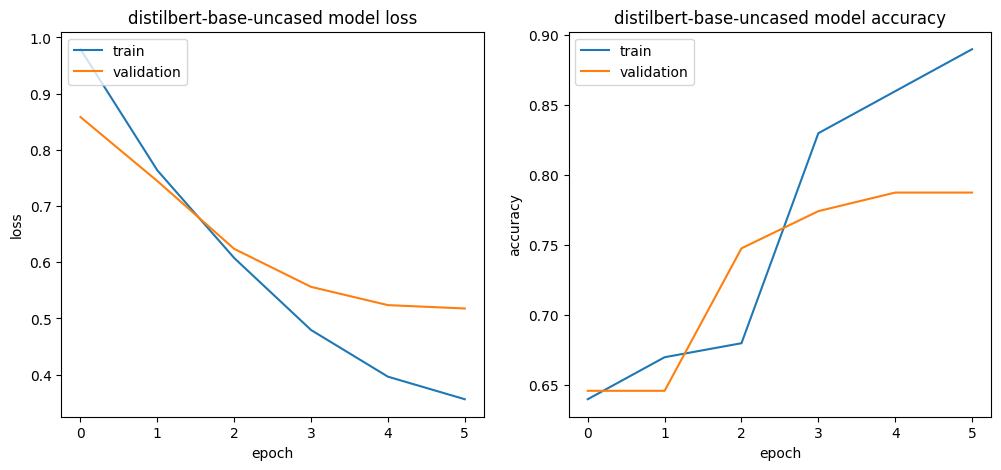

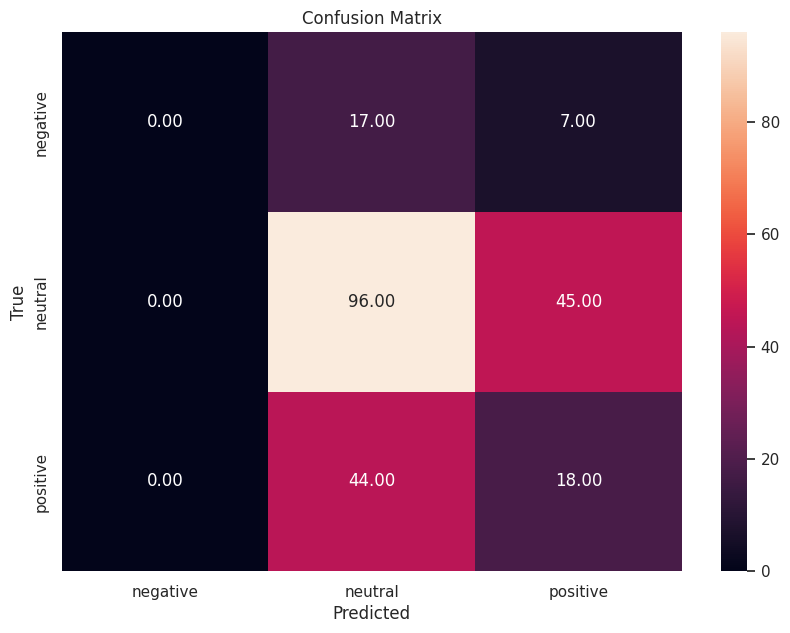

Model           distilbert-base-uncased
Fine Method       fine_tune_all_weights
Sub-Dataset                   All_agree
Train Size                          100
Dataset Type                 tf_dataset
train loss                     0.335911
train acc                           0.9
val loss                       0.517683
val acc                        0.787611
test loss                      0.580079
test acc                       0.788546
Name: 0, dtype: object

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.01881839893758297, 'train_accuracy': 0.9980000257492065, 'val_loss': 0.15248338878154755, 'val_accuracy': 0.9513274431228638, 'test_loss': 0.3049599826335907, 'test_accuracy': 0.9207048416137695}
29/29 [==============================] - 4s 33ms/step
              precision    recall  f1-score   support

           0      0.240     0.250     0.245        24
           1      0.632     0.610     0.621       141
           2      0.288     0.306     0.297        62

    accuracy                          0.489       227
   macro avg      0.387     0.389     0.388       227
weighted avg      0.497     0.489     0.493       227



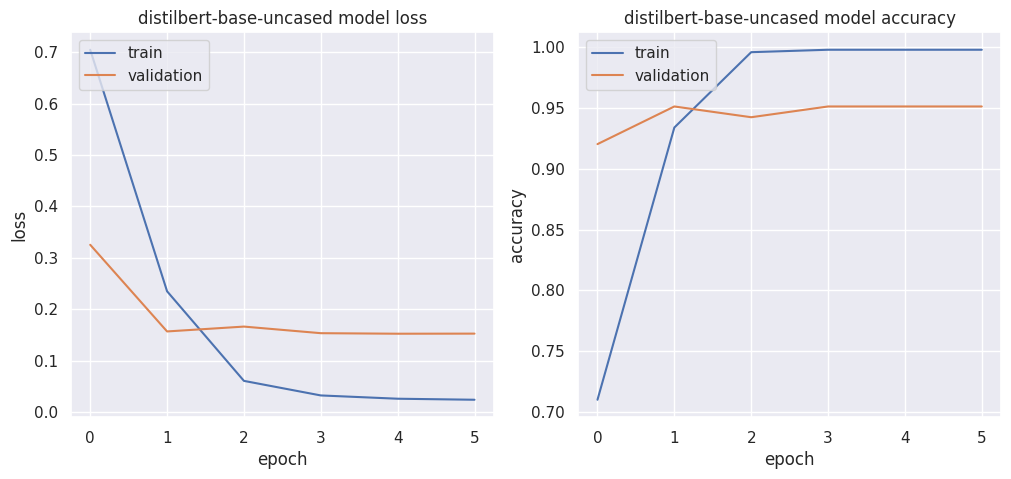

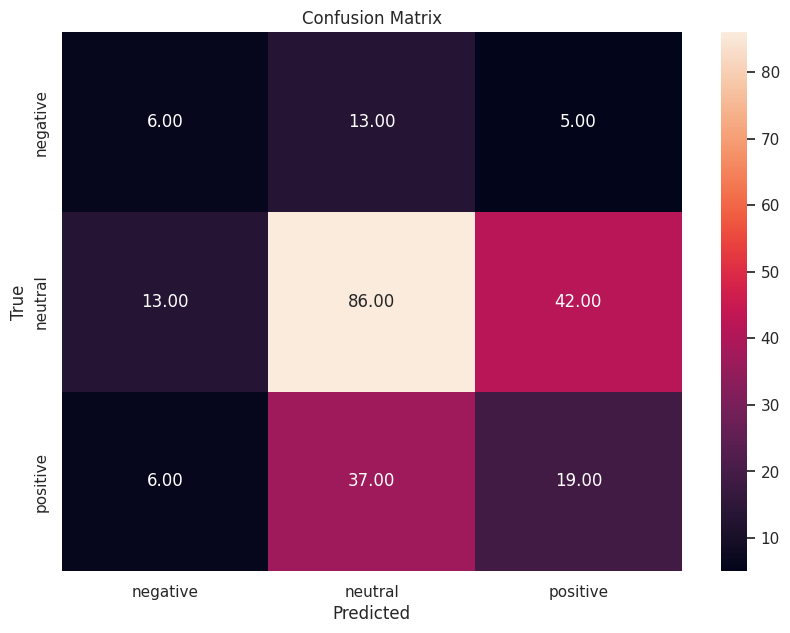

Model           distilbert-base-uncased
Fine Method       fine_tune_all_weights
Sub-Dataset                   All_agree
Train Size                          500
Dataset Type                 tf_dataset
train loss                     0.018818
train acc                         0.998
val loss                       0.152483
val acc                        0.951327
test loss                       0.30496
test acc                       0.920705
Name: 1, dtype: object

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{'train_loss': 0.010809850879013538, 'train_accuracy': 0.9990000128746033, 'val_loss': 0.09912615269422531, 'val_accuracy': 0.9646017551422119, 'test_loss': 0.17993900179862976, 'test_accuracy': 0.9471365809440613}
29/29 [==============================] - 3s 43ms/step
              precision    recall  f1-score   support

           0      0.045     0.042     0.043        24
           1      0.632     0.610     0.621       141
           2      0.275     0.306     0.290        62

    accuracy                          0.467       227
   macro avg      0.318     0.319     0.318       227
weighted avg      0.473     0.467     0.470       227



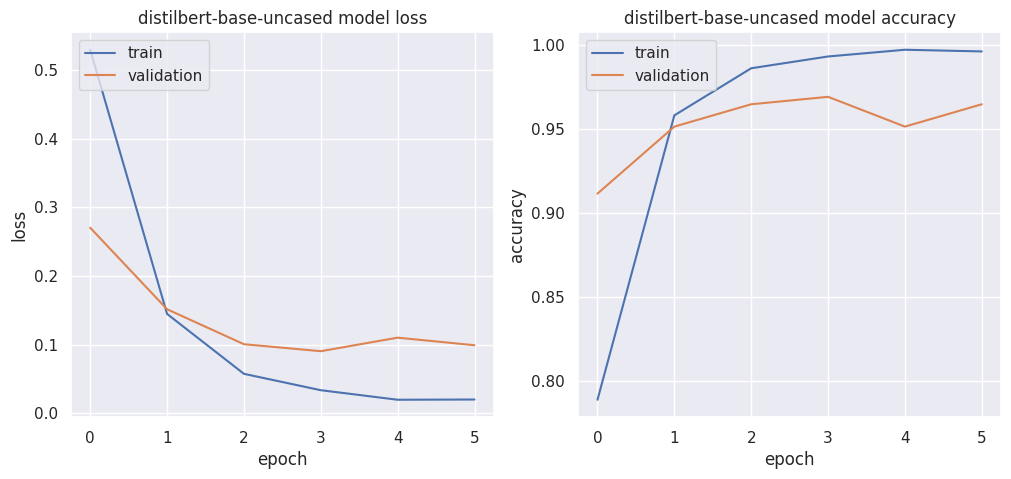

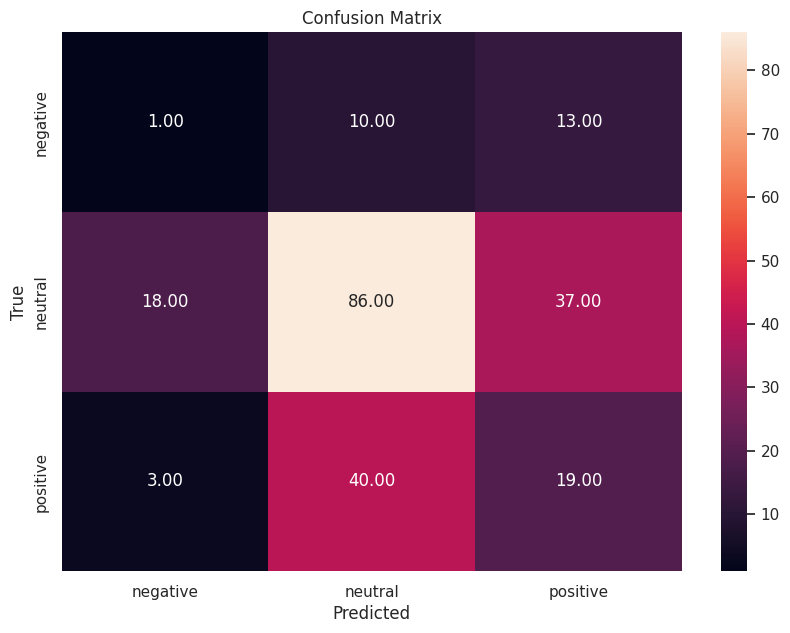

Model           distilbert-base-uncased
Fine Method       fine_tune_all_weights
Sub-Dataset                   All_agree
Train Size                         1000
Dataset Type                 tf_dataset
train loss                      0.01081
train acc                         0.999
val loss                       0.099126
val acc                        0.964602
test loss                      0.179939
test acc                       0.947137
Name: 2, dtype: object

In [ ]:
checkpoint = "distilbert-base-uncased"
model_name = "distilbert-base-uncased"
batch_size = 8
num_epochs = 6
for sub_data in [tf_train_dataset_100, tf_train_dataset_500, tf_train_dataset_1000]:
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    num_train_steps = len(sub_data) * num_epochs
    lr_scheduler = PolynomialDecay(initial_learning_rate=3e-5, end_learning_rate=0.0, decay_steps=num_train_steps)
    opt = Adam(learning_rate=lr_scheduler)
    model, score = train_model_tfds(model_name, model, opt, sub_data, tf_validation_dataset, batch_size, num_epochs)

    # model = load_model(model_name, fine_method, sub_dataset, train_size, dataset_type)
    # save_model(model, model_name, fine_method, sub_dataset, train_size, dataset_type)
    score = evaluate_model_tfds(model, tf_test_dataset, score)

    model_name = "distilbert-base-uncased"
    fine_method = 'fine_tune_all_weights'
    sub_dataset = 'All_agree'
    if sub_data == tf_train_dataset_100:
        train_size = 100
    elif sub_data == tf_train_dataset_500:
        train_size = 500
    elif sub_data == tf_train_dataset_1000:
        train_size = 1000
    dataset_type = 'tf_dataset'
    summary_table = record_model_summary(summary_table, model_name, fine_method, sub_dataset, train_size, dataset_type, score)
    display(summary_table.iloc[-1,:])

In [ ]:
display(summary_table.iloc[[-3,-2,-1],:])

,Model,Fine Method,Sub-Dataset,Train Size,Dataset Type,train loss,train acc,val loss,val acc,test loss,test acc
0,distilbert-base-uncased,fine_tune_all_weights,All_agree,100,tf_dataset,0.335911,0.900,0.517683,0.787611,0.580079,0.788546
1,distilbert-base-uncased,fine_tune_all_weights,All_agree,500,tf_dataset,0.018818,0.998,0.152483,0.951327,0.304960,0.920705
2,distilbert-base-uncased,fine_tune_all_weights,All_agree,1000,tf_dataset,0.010810,0.999,0.099126,0.964602,0.179939,0.947137


The experiment shows that training the model with just 100 data points results in performance scores ranging between 0.65 and 0.78. Remarkably, when the training data is increased to 500, the scores improve significantly, falling between 0.92 and 0.95. These scores are nearly as good as those achieved with even larger datasets of 1000 or 1811 data points. This demonstrates the effectiveness of fine-tuning a well-pre-trained model with a relatively small dataset.

Furthermore, the selection of data for these subsets is crucial for model performance. A diverse subset allows the model to train effectively even with fewer data points. In contrast, a biased subset, such as one containing only positive examples, limits the model's ability to recognize "neutral" or "negative" sentiments. Therefore, choosing unbiased and representative data is key for successful model training.

## In-context Learning

The task at hand involves determining the subject and sentiment expressed in a given sentence. For this task, we have a total of 7 sentences to use as training examples and 1 sentence to evaluate as a test case. The model will have 5 opportunities to guess the correct answers. The model being used for this task is 'GPT-2'.

In [ ]:
generator = pipeline('text-generation', model='gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
exemplars = ["Nike has no plans to move all production to Southeast Asia.: Nike - neutral",
             "Componenta's net sales doubled: Componenta - positive",
             "Costco's operating margin came down to 2.4%: Costco - negative",
             "Amazon reports its profit increased: Amazon - positive",
             "Nokia shares go down to 13.21 euros: Nokia - negative",
             "Nordea Group's operating profit increased in 2010: Nordea - positive",
             "Uponor maintains its full-year guidance for 2010: Uponor - neutral",
]

In [ ]:
acc = []
for k in range(7):
    sep = "\n"
    exemplar_string = sep.join(exemplars[0:k+1])
    few_shot_string =  exemplar_string + sep + "Tielinja increased net sales to $ 9.6 mn in 2005:"
    correct_ans = "Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive"

    shot_num = 5
    resp = generator(few_shot_string, max_length = 300, num_return_sequences=shot_num,
                    top_k=4, top_p=0.8,)

    correct_shot = 0
    for i, gen in enumerate(resp):
        print(gen['generated_text'].split('\n')[k+1])
        if gen['generated_text'].split('\n')[k+1] == correct_ans:
            correct_shot = correct_shot + 1

    acc.append(correct_shot/shot_num)
    print('Given {s1:d} samples, Accuracy score: {s2:.2f}'.format(s1=k+1, s2=acc[-1]))
    print('\n')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Given 1 samples, Accuracy score: 0.00




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Given 2 samples, Accuracy score: 0.60




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 3 samples, Accuracy score: 1.00




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Given 4 samples, Accuracy score: 0.40




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Nokia - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 5 samples, Accuracy score: 0.20




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Given 6 samples, Accuracy score: 0.00


Tielinja increased net sales to $ 9.6 mn in 2005: Uponor - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 7 samples, Accuracy score: 0.80




Text(0.5, 0, 'Number of Shots')

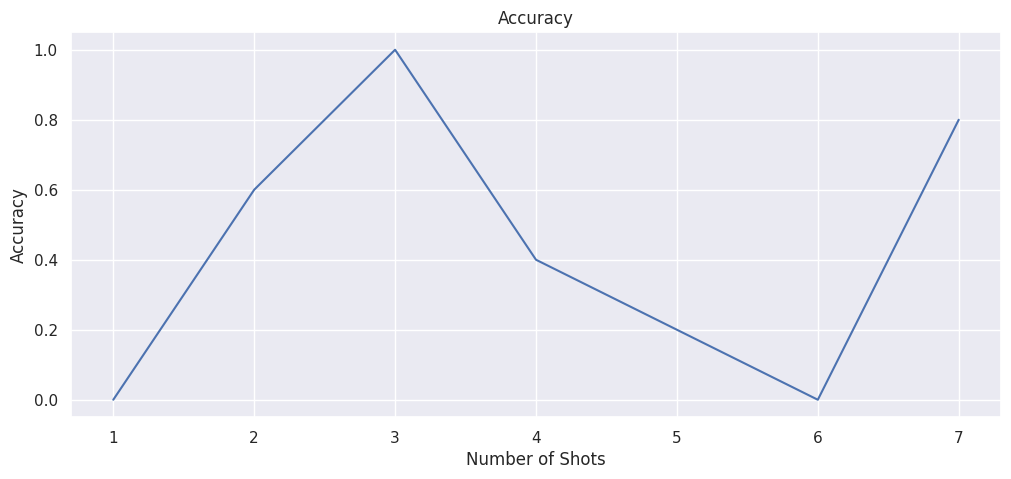

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(list(range(1,8)), acc)
ax.set_title('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Shots')

Only the second, third, and seventh training samples can make the model have 0.6-1.0 accuracy. However, the fifth to seventh training samples didn't help improve the model performance. It may be because of the sample quality. If we give the model more data, the model performance may probably be improved and become more stable.

## Show the result of each model above

In [ ]:
display(summary_table.iloc[:,:])

,Model,Fine Method,Sub-Dataset,Train Size,Dataset Type,train loss,train acc,val loss,val acc,test loss,test acc
0,distilbert-base-uncased,fine-tune_head_only,All_agree,1811,np_dataset,0.488201,0.770845,0.533308,0.769912,0.483699,0.779736
1,distilbert-base-uncased,Keep_head_fine-tune_all_weights,All_agree,1811,np_dataset,0.021302,0.994478,0.140638,0.960177,0.077679,0.977974
2,distilbert-base-uncased,fine-tune_all_weights,All_agree,1811,np_dataset,0.014163,0.995030,0.168488,0.964602,0.205284,0.955947
3,distilbert-base-uncased,fine-tune_head_only,All_agree,1811,tf_dataset,0.004723,0.998896,0.220773,0.955752,0.183524,0.964758
4,distilbert-base-uncased,Keep_head_fine-tune_all_weights,All_agree,1811,tf_dataset,0.000379,1.000000,0.252243,0.960177,0.174451,0.977974
5,distilbert-base-uncased,fine-tune_all_weights,All_agree,1811,tf_dataset,0.005247,0.999448,0.092343,0.977876,0.108690,0.977974
6,custom_model,fine-tune_all_weights,All_agree,1811,np_dataset,0.005032,0.998343,0.207583,0.964602,0.121531,0.977974
7,distilbert-base-uncased,fine-tune_all_weights,sentences_75agree,346,tf_dataset,0.007148,0.998552,0.317246,0.924638,0.238789,0.947977
8,distilbert-base-uncased,fine-tune_all_weights,sentences_66agree,422,tf_dataset,0.021999,0.992588,0.482712,0.869668,0.483528,0.860190
9,distilbert-base-uncased,fine-tune_all_weights,sentences_50agree,485,tf_dataset,0.244635,0.915377,0.390853,0.830928,0.428028,0.822680
